In [1]:
import os
import time
import yaml

import cv2
import pickle
import numpy as np
import contextlib
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchinfo import summary
from torchvision.models.detection.keypoint_rcnn import KeypointRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.keypoint_rcnn import KeypointRCNNPredictor

import albumentations as A
from albumentations.pytorch import ToTensorV2
from ultralytics import YOLO
import json

import timm
from copy import deepcopy
from helpers.helpers import plot_yolo_keypoints, analyze_yolo_dataset, plot_4x, clean_img_dir_and_labels

plt.style.use("https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle")

/opt/conda/envs/pingpong/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
CONFIG = {
    'DATASET_DIR': '/mnt/dl/Projects/human_pose_estimation/datasets/postures',
    'IM_SIZE': 256,
    'NUM_STACKS': 8,
    'NUM_BLOCKS': 4,
    'NUM_KEYPOINTS': 25,
    'OUT_RES': 64,
    'BATCH_SIZE': 4,
    'NUM_EPOCHS': 1000,
    'PATIENCE': 20,
    'NUM_WORKERS': os.cpu_count(),
    'PIN_MEMORY': True,
    'SIGMAS': [
                    0.026,  # 0: right eye
                    0.025,  # 1: nose
                    0.026,  # 2: left eye
                    0.079,  # 3: neck
                    0.079,  # 4: right shoulder
                    0.072,  # 5: right elbow
                    0.062,  # 6: right wrist
                    0.062,  # 7: right hand thumb (approximated, not part of COCO but similar to wrist)
                    0.062,  # 8: right hand pinky (approximated, similar to wrist)
                    0.079,  # 9: left shoulder
                    0.072,  # 10: left elbow
                    0.062,  # 11: left wrist
                    0.062,  # 12: left hand pinky (approximated, similar to wrist)
                    0.062,  # 13: left hand thumb (approximated, similar to wrist)
                    0.087,  # 14: torso
                    0.087,  # 15: right hip
                    0.087,  # 16: left hip
                    0.089,  # 17: right knee
                    0.089,  # 18: right foot (approximated, similar to ankle)
                    0.089,  # 19: right foot fingertips (approximated, similar to ankle)
                    0.087,  # 20: right ankle
                    0.089,  # 21: left knee
                    0.087,  # 22: left ankle
                    0.089,  # 23: left foot (approximated, similar to ankle)
                    0.089   # 24: left foot fingertips (approximated, similar to ankle)
                ]


}

In [4]:
# clean_img_dir_and_labels(CONFIG['DATASET_DIR'])

## Data visualization

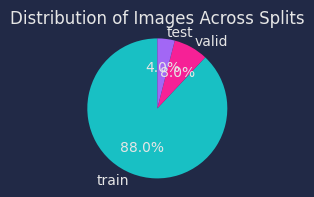

Split  Image Count Percentage
0  train         1578     88.01%
1  valid          143      7.98%
2   test           72      4.02%

In [5]:
ds_dir = os.path.join(os.getcwd(),CONFIG['DATASET_DIR'])
analyze_yolo_dataset(ds_dir)

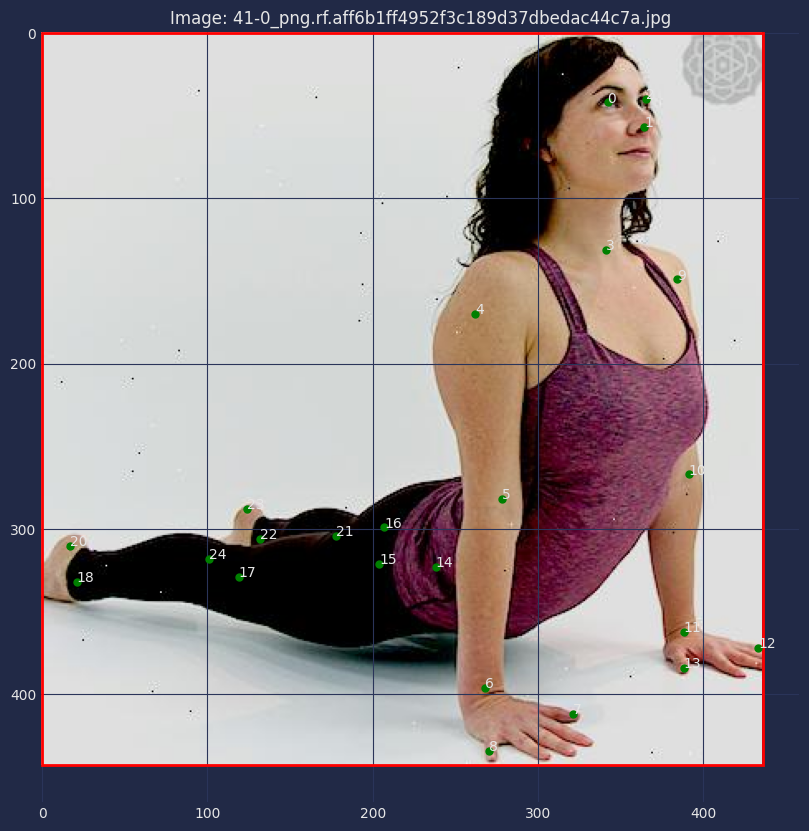

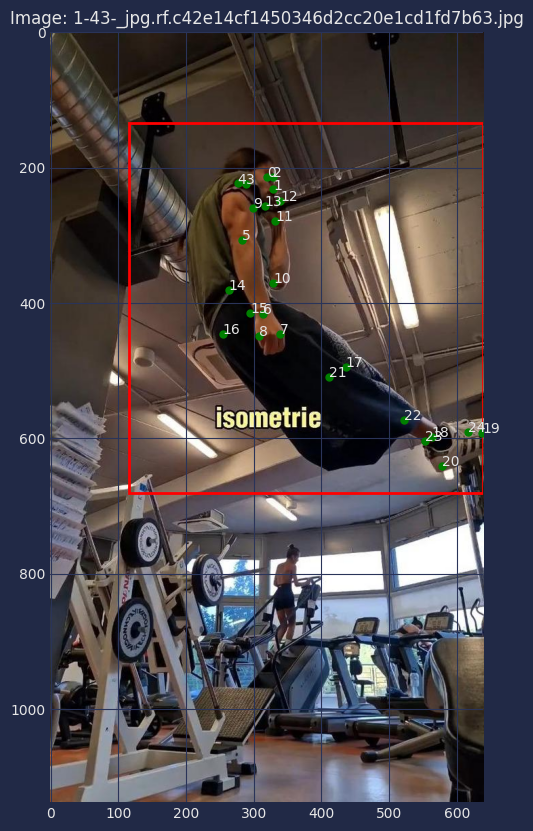

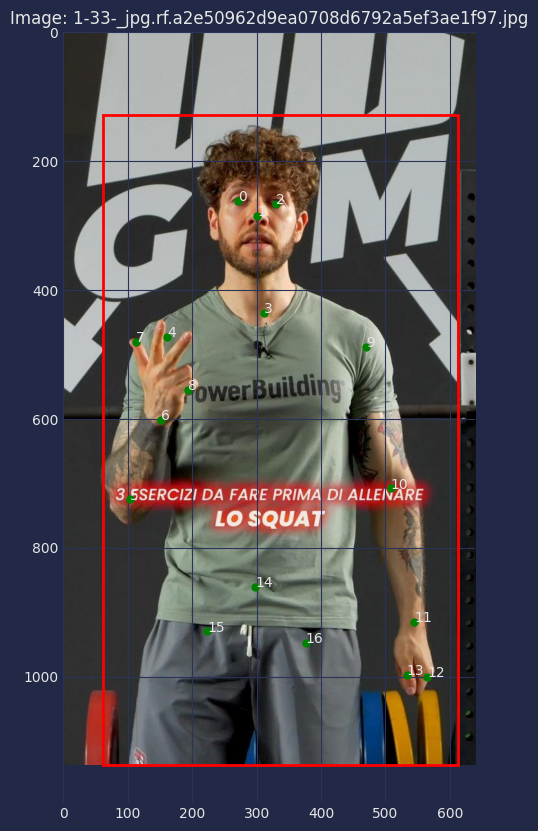

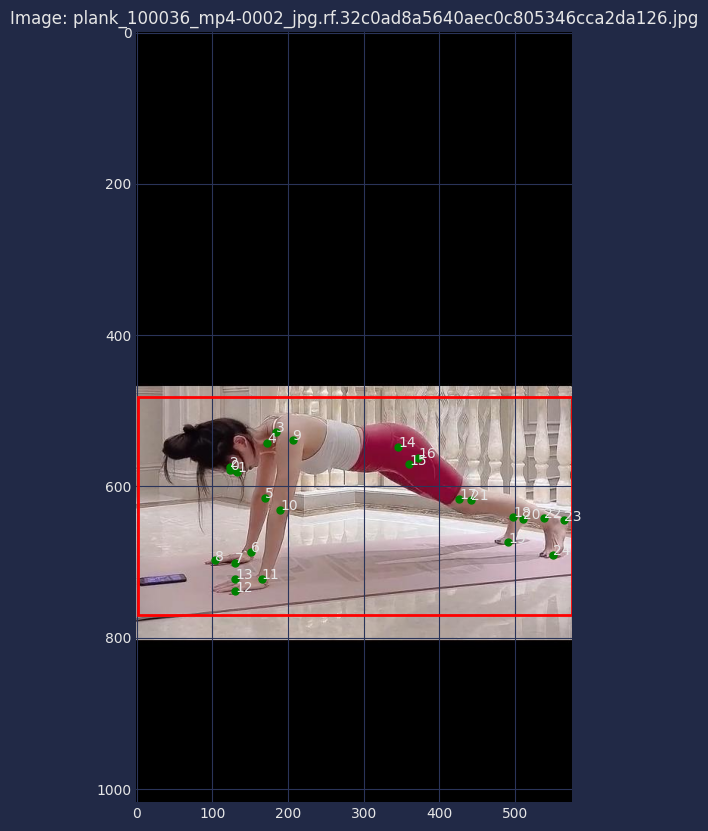

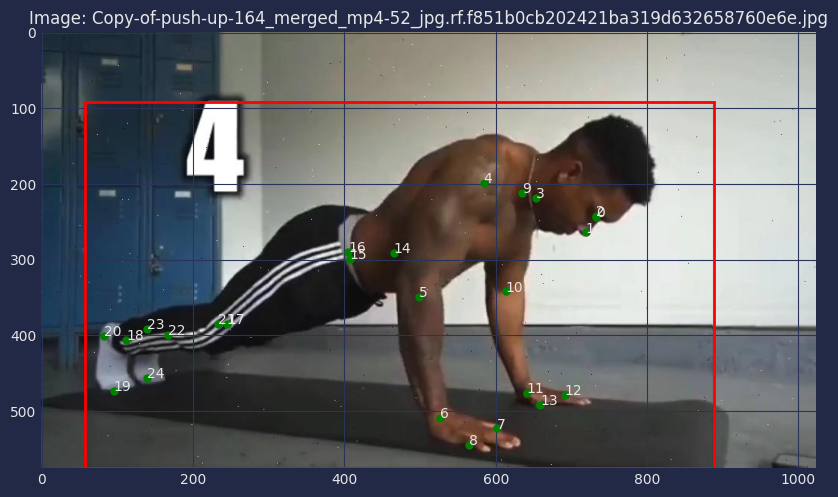

In [6]:
plot_yolo_keypoints(ds_dir)

# Modeling

In [4]:
def compute_pck(batch_pred_keypoints, batch_gt_keypoints, batch_gt_bboxes, thresholds=[0.01, 0.05, 0.1], extract=None):
    """
    Calculate the mean Percentage of Correct Keypoints (mPCK) and extracts a list of PCKs for specified thresholds for a batch of images.

    :param batch_cropped_images: Padded images after cropping and resizing the object [batch_size, num_channels, height, width].
    :param batch_pred_keypoints: List of predicted keypoints [batch_size, num_boxes, num_keypoints, 2].
    :param batch_gt_keypoints: List of ground truth keypoints [batch_size, num_boxes, num_keypoints, 2].
    :param batch_gt_bboxes: List of ground truth bboxes [batch_size, num_boxes, 4].
    :param thresholds: List of threshold percentages of object size for PCK calculation.
    :param extract: List of PCK threshold values to extract (e.g., PCK@0.1).
    :return: mPCK score (mean PCK over thresholds) and extracted PCK values.
    """
    if extract is None:
        extract = []
    thresholds = list(set(thresholds + extract))  # Ensure all extract values are in thresholds
    thresholds.sort()  # Sort for consistency

    all_correct_keypoints = []

    for pred_kpts, gt_kpts, gt_bboxes in zip(batch_pred_keypoints, batch_gt_keypoints, batch_gt_bboxes):
        for box_pred_kpts, box_gt_kpts, gt_bbox in zip(pred_kpts, gt_kpts, gt_bboxes):
            # Calculate object size (use area as the normalization factor)
            object_size = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
            
            # Calculate Euclidean distance between predicted and ground truth keypoints
            distances = np.sqrt(np.sum((box_pred_kpts - box_gt_kpts) ** 2, axis=1))  # Shape: [num_keypoints]
            
            # Add new axis to distances for broadcasting with thresholds
            # New shape: [num_keypoints, 1]
            distances_expanded = distances[:, np.newaxis]
            
            # Calculate correct keypoints for all thresholds
            # Shape: [num_keypoints, num_thresholds]
            correct_keypoints = distances_expanded < (np.array(thresholds) * np.sqrt(object_size))
            
            all_correct_keypoints.append(correct_keypoints)
    
    # Stack all correct keypoints across the batch and boxes
    # Shape: [total_boxes, num_keypoints, num_thresholds]
    if len(all_correct_keypoints) > 0:
        all_correct_keypoints = np.stack(all_correct_keypoints, axis=0)
        
        # Calculate PCK for each threshold
        # Shape: [num_thresholds]
        pck_values = np.mean(all_correct_keypoints, axis=(0, 1))
        
        # Calculate mean PCK (mPCK) across all thresholds
        mPCK = np.mean(pck_values)
        
        # Extract specific PCK values as requested
        extracted_pcks = {f'PCK@{val}': pck_values[thresholds.index(val)] for val in extract}

        return mPCK, extracted_pcks
    else:
        return 0, None

In [5]:
class OKSCalculator:
    def __init__(self, sigmas):
        self.sigmas = np.array(sigmas)

import numpy as np

class OKSCalculator:
    def __init__(self, sigmas):
        self.sigmas = np.array(sigmas)

    def compute_oks(self, pred_keypoints_list, gt_keypoints_list, bboxes_list):
        """
        Compute OKS for a batch of predictions with trimming and padding only on predictions.

        Args:
        - pred_keypoints_list: list of predicted keypoints [B, N, K, 2]
        - gt_keypoints_list: list of ground truth keypoints [B, M, K, 3]
        - bboxes_list: list of bounding boxes of the objects [B, N, 4]

        Returns:
        - oks_scores: OKS scores for each image in the batch [B]
        """
        oks_scores = []

        for pred_keypoints, gt_keypoints, bboxes in zip(pred_keypoints_list, gt_keypoints_list, bboxes_list):
            # Get the number of predicted and ground truth keypoints
            pred_count = pred_keypoints.shape[0]
            gt_count = gt_keypoints.shape[0]

            # Trim or pad predicted keypoints based on ground truth
            if pred_count > gt_count:
                pred_keypoints = pred_keypoints[:gt_count]  # Trim excess predictions
            elif pred_count < gt_count:
                padding = np.zeros((gt_count - pred_count, pred_keypoints.shape[1], 3))  # Create padding with zeros
                pred_keypoints = np.concatenate([pred_keypoints, padding], axis=0)  # Pad with zeros

            # Calculate areas from bboxes
            areas = (bboxes[:, 2] - bboxes[:, 0]) * (bboxes[:, 3] - bboxes[:, 1])
            epsilon = 1e-5
            areas = np.maximum(areas, epsilon)  # Avoid division by zero

            # Calculate Euclidean distances
            dx = pred_keypoints[..., 0] - gt_keypoints[..., 0]
            dy = pred_keypoints[..., 1] - gt_keypoints[..., 1]

            # Get visibility mask
            visible_mask = (gt_keypoints[..., 2] > 0)  # Visibility flag in the 3rd channel

            # Compute OKS score
            e = (dx**2 + dy**2) / (2 * (areas[:, None] * (self.sigmas**2)))  # Broadcasting to [N, K]
            oks_score = (np.exp(-e) * visible_mask).sum(axis=1) / visible_mask.sum(axis=1)  # Sum over keypoints

            # Store the mean OKS score for the current image
            oks_scores.append(oks_score.mean())

        return np.array(oks_scores)  # Convert to numpy array for output consistency

def compute_ap(oks_scores, thresholds=np.arange(0.5, 1.0, 0.05)):
    """
    Compute Average Precision based on OKS scores.
    
    Args:
    - oks_scores: list of OKS scores [B]
    - thresholds: OKS thresholds for AP calculation
    
    Returns:
    - ap_results: dictionary of AP results for each threshold
    """
    ap_results = {}
    for threshold in thresholds:
        tp = (oks_scores >= threshold).astype(int)
        fp = 1 - tp
        tp_cum = np.cumsum(tp)
        fp_cum = np.cumsum(fp)
        recall = tp_cum / len(oks_scores)
        precision = tp_cum / (tp_cum + fp_cum + 1e-10)  # Add epsilon to avoid division by zero
        ap = np.trapz(precision, recall)
        ap_results[f'AP@{threshold:.2f}'] = ap
    ap_results['mAP'] = np.mean(list(ap_results.values()))
    return ap_results

## Hourglass network `from scratch`

In [9]:
class GenerateHeatmap():
    def __init__(self, output_res, num_parts, input_res):
        self.output_res = output_res
        self.num_parts = num_parts
        self.input_res = input_res
        self.sigma = self.output_res / 64

        size = 6 * self.sigma + 3
        x = np.arange(0, size, 1, float)
        y = x[:, np.newaxis]

        x0, y0 = 3 * self.sigma + 1, 3 * self.sigma + 1
        self.g = np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * self.sigma ** 2))

    def scale_keypoints(self, keypoints):
        scale_factor = self.output_res / self.input_res
        
        return [(int(x * scale_factor), int(y * scale_factor)) for x, y in keypoints]

    def __call__(self, keypoints):
        hms = np.zeros((self.num_parts, self.output_res, self.output_res), dtype=np.float32)
        sigma = self.sigma
        keypoints = self.scale_keypoints(keypoints)  # Scale keypoints
        for idx, pt in enumerate(keypoints):
            if pt[0] > 0:
                x, y = int(pt[0]), int(pt[1])

                if x < 0 or y < 0 or x >= self.output_res or y >= self.output_res:
                    continue

                ul = int(x - 3 * sigma - 1), int(y - 3 * sigma - 1)
                br = int(x + 3 * sigma + 2), int(y + 3 * sigma + 2)

                # Gaussian kernel coordinates on the grid 
                c, d = max(0, -ul[0]), min(br[0], self.output_res) - ul[0]
                a, b = max(0, -ul[1]), min(br[1], self.output_res) - ul[1]

                # Keypoints coordinates on the grid
                cc, dd = max(0, ul[0]), min(br[0], self.output_res)
                aa, bb = max(0, ul[1]), min(br[1], self.output_res)

                hms[idx, aa:bb, cc:dd] = np.maximum(hms[idx, aa:bb, cc:dd], self.g[a:b, c:d])

        return hms

In [10]:
class HeatmapParser:
    def __init__(self):
        # Initialize MaxPool2d for non-maximum suppression (NMS)
        self.pool = nn.MaxPool2d(3, 1, 1)

    def nms(self, heatmaps):
        """
        Apply Non-Maximum Suppression (NMS) to the heatmaps.
        
        :param heatmaps: Heatmaps tensor [batch_size, num_keypoints, nstacks, height, width]
        :return: Heatmaps after applying NMS with the same shape.
        """
        
        batch_size, nstacks, num_keypoints, height, width = heatmaps.shape
        # Reshape the heatmaps to apply NMS to each stack independently
        heatmaps = heatmaps.view(batch_size, nstacks  * num_keypoints, height, width)

        # Apply max pooling for NMS
        maxm = self.pool(heatmaps)  # Apply pooling
        maxm = torch.eq(maxm, heatmaps).float()  # Create mask for local maxima
        
        # Element-wise multiply to apply NMS
        heatmaps = heatmaps * maxm
        
        # Reshape back to original shape
        heatmaps = heatmaps.view(batch_size, nstacks, num_keypoints, height, width)
        
        return heatmaps

    def calc(self, nms_heatmaps):
        """
        Extract keypoint locations and confidence scores after applying NMS.
        
        :param nms_heatmaps: Heatmaps array after NMS [batch_size, nstacks, num_keypoints, height, width]
        :return: Dictionary with 'loc_k' (locations) and 'val_k' (confidence values)
        """
        batch_size, nstacks, num_keypoints, height, width = nms_heatmaps.shape
        
        # Flatten the spatial dimensions to find the top keypoints
        nms_heatmaps = nms_heatmaps.reshape(batch_size, nstacks, num_keypoints, -1)  # [batch_size, num_keypoints, nstacks, height * width]
        # Get the maximum value (confidence) and the corresponding index (location)
        val_k = np.max(nms_heatmaps, axis=3, keepdims=True)  # Top-1 value (confidence) for each keypoint
        ind = np.argmax(nms_heatmaps, axis=3, keepdims=True)  # Index of the top-1 keypoint
        
        # Calculate (x, y) coordinates from the index
        x = ind % width  # x-coordinate
        y = ind // width  # y-coordinate
        
        # Stack x and y coordinates
        loc_k = np.stack((x, y), axis=4)  # Shape: [batch_size, num_keypoints, nstacks, 1, 2]
        
        # Prepare the result dictionary
        keypoints = {'loc_k': loc_k, 'val_k': val_k}
        
        return keypoints

    def adjust(self, ans, det):
        """
        Adjust keypoint locations based on heatmap values.
        
        :param ans: Dictionary with 'loc_k' and 'val_k'
        :param det: Heatmaps tensor
        :return: Adjusted keypoints
        """
        for batch_id, people in enumerate(ans): 
            for people_id, i in enumerate(people):
                for joint_id, joint in enumerate(i):
                    if joint[2] > 0:  # If the keypoint is visible
                        y, x = joint[0:2]
                        xx, yy = int(x), int(y)
                        tmp = det[0][joint_id]  # Get the specific heatmap for the joint
                        
                        # Adjust y-coordinate
                        if tmp[xx, min(yy + 1, tmp.shape[1] - 1)] > tmp[xx, max(yy - 1, 0)]:
                            y += 0.25
                        else:
                            y -= 0.25
                        
                        # Adjust x-coordinate
                        if tmp[min(xx + 1, tmp.shape[0] - 1), yy] > tmp[max(0, xx - 1), yy]:
                            x += 0.25
                        else:
                            x -= 0.25
                        
                        ans[0][0, joint_id, 0:2] = (y + 0.5, x + 0.5)  # Update adjusted coordinates
        return ans

    def parse(self, det, adjust=False):
        """
        Parse and adjust heatmap detections.
        
        :param det: Heatmaps tensor
        :param adjust: Whether to adjust keypoint locations
        :return: List of adjusted keypoints
        """
        ans = self.calc(det)  # Get the keypoint locations and values
        if adjust:
            ans = self.adjust(ans, det)  # Optionally adjust the keypoints
        return ans

In [ ]:
# Custom dataset to load the images, and keypoints then generate heatmaps for hourglass network using a yolov8 dataset
class HGNYOLOv8KptsDataset(Dataset):
    def __init__(self, config, transforms, split):
        """
        Initializes the dataset based on the split.
        
        Args:
            config_path (str): Path to the YAML configuration file.
            split (str): The split to load ('train', 'val', 'test').
        """
        # Load dataset config file
        ds_config_path = os.path.join(config['DATASET_DIR'], 'data.yaml')
        try:
            with open(ds_config_path, 'r') as file:
                ds_config = yaml.safe_load(file)
        except Exception as e:
            raise e
        self.config = config
        self.img_dir = os.path.join(ds_config['path'], split, 'images')
        self.label_dir = self.img_dir.replace('images', 'labels')
        self.img_list = os.listdir(self.img_dir)
        self.label_list = os.listdir(self.label_dir)
        self.transforms = transforms

        self.input_res = self.config['IM_SIZE']
        self.output_res = self.config['OUT_RES']
        # Create an instance of the GenerateHeatmap class to generate heatmaps from keypoints.
        self.generateHeatmap = GenerateHeatmap(self.output_res, self.config['NUM_KEYPOINTS'], self.input_res)
            
        # Define directory paths based on split
        self.split = split.lower()
        assert self.split in ['train', 'val', 'valid', 'validation', 'test'], "Split must be one of 'train', 'val', 'test'"
                
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_list[idx])
        label_path = os.path.join(self.label_dir,self.label_list[idx])
        
        img = np.array(Image.open(img_path).convert("RGB"))
        img_height, img_width = img.shape[:2]

        keypoints, _, bbox, _ = self.loadLabel(label_path,img_height, img_width)
        
        # Clamp keypoints to be within the image dimensions
        keypoints = np.clip(keypoints, 0, [img_width - 1, img_height - 1])
        
        transforms = self.transforms(bbox)
        if transforms.to_dict()['transform']['keypoint_params']:
            augmentations = transforms(image=img, keypoints=keypoints)
            img = augmentations['image']
            keypoints = augmentations['keypoints']
        else:
            augmentations = transforms(image=img)
            img = augmentations['image']
        
        heatmap = self.generateHeatmap(keypoints)
        
        return img, heatmap
    
    def loadLabel(self, label_path, img_height, img_width):
        """
        Parse the label data, denormalize the coordinates, and return in the required format.
        
        Args:
            label_path (str): The path of the label file.
            img_width (int): Width of the image.
            img_height (int): Height of the image.
            
        Returns:
            keypoints (np.array): Array of shape (n, 2) containing [x, y] for each keypoint.
            cls_id (np.array): Array of shape (n,) containing [class_id,].
            bbox (np.array): Array of shape (4,) containing [x_center, y_center, width, height].
            vis (np.array): Array of shape (n,) containing the visibility flag [v].
        """
        # TABLE_WIDTH_M = 2.74
        # TABLE_HEIGHT_M = 1.525
        keypoints = []
        cls_id = []
        vis = []
        
        label_data = np.loadtxt(fname=label_path, delimiter=" ", ndmin=2)
        if label_data.size > 0:
            parts = label_data[0]
            num_keypoints = (len(parts) - 5) // 3  # Number of keypoints
            class_id = float(parts[0])
            x_center = float(parts[1]) * img_width  # Denormalizing x_center
            y_center = float(parts[2]) * img_height # Denormalizing y_center
            width = float(parts[3]) * img_width     # Denormalizing width
            height = float(parts[4]) * img_height   # Denormalizing height
            x_min = x_center - width / 2
            y_min = y_center - height / 2
            x_max = x_center + width / 2
            y_max = y_center + height / 2
            
            cls_id.append([class_id,])
            bbox = [int(x_min), int(y_min), int(x_max), int(y_max)]
            for i in range(num_keypoints):
                x = float(parts[5 + 3*i]) * img_width    # Denormalizing x
                y = float(parts[6 + 3*i]) * img_height   # Denormalizing y
                visibility = int(parts[7 + 3*i])
                
                keypoints.append([int(x), int(y)])
                vis.append(visibility)
        else:
            return (np.zeros(shape=(self.config['NUM_KEYPOINTS'],2)), 
                    np.zeros(shape=(1,)),
                    np.array([1,2,3,4]),
                    np.zeros(shape=(1,))
                    )
                    
        return (
            np.array(keypoints), 
            np.array(cls_id), 
            np.array(bbox), 
            np.array(vis),
        )

In [ ]:
def hgn_train_transforms(bbox):
    return A.Compose([
            A.Crop(x_min=bbox[0], y_min=bbox[1], x_max=bbox[2], y_max=bbox[3], always_apply=True),  # Crop around bbox
            A.LongestMaxSize(max_size=CONFIG['IM_SIZE']),
            A.PadIfNeeded(min_height=CONFIG['IM_SIZE'], min_width=CONFIG['IM_SIZE'], border_mode=0, value=0),  # Pad to maintain aspect ratio
            # A.RGBShift(p=0.2),
            # A.GaussianBlur(blur_limit=(3, 7), p=0.2),
            # A.HorizontalFlip(p=0.5),  # Random horizontal flip
            # A.RandomBrightnessContrast(p=0.2),  # Random brightness and contrast adjustment
            # A.Affine(
            #     scale=(0.8, 1.2),  # Random scaling (80% to 120%)
            #     translate_percent=(0.1, 0.1),  # Translation (up to 10%)
            #     rotate=15,  # Additional rotation (±15 degrees)
            #     p=0.3  # Probability of applying affine transformation  
            # ),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize image
            ToTensorV2(),  # Convert to tensor
        ], keypoint_params=A.KeypointParams(format='xy'))  # Handle keypoints


def hgn_val_test_transforms(bbox):
    return A.Compose([
            A.Crop(x_min=bbox[0], y_min=bbox[1], x_max=bbox[2], y_max=bbox[3]),  # Crop around bbox
            A.LongestMaxSize(max_size=CONFIG['IM_SIZE']),
            A.PadIfNeeded(min_height=CONFIG['IM_SIZE'], min_width=CONFIG['IM_SIZE'], border_mode=0, value=0),  # Pad to maintain aspect ratio
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ], keypoint_params=A.KeypointParams(format='xy'))
    
def hgn_preprocess_transforms(bbox):
        return A.Compose([
            A.Crop(x_min=bbox[0], y_min=bbox[1], x_max=bbox[2], y_max=bbox[3]),  # Crop around bbox
            A.LongestMaxSize(max_size=CONFIG['IM_SIZE']),
            A.PadIfNeeded(min_height=CONFIG['IM_SIZE'], min_width=CONFIG['IM_SIZE'], border_mode=0, value=0),  # Pad to maintain aspect ratio
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

In [ ]:
# Instantiate the datasets
hgn_train_dataset = HGNYOLOv8KptsDataset(config=CONFIG, transforms=hgn_train_transforms, split='train')
hgn_val_dataset = HGNYOLOv8KptsDataset(config=CONFIG, transforms=hgn_val_test_transforms, split='valid')
hgn_test_dataset = HGNYOLOv8KptsDataset(config=CONFIG, transforms=hgn_val_test_transforms, split='valid')
hgn_train_loader = DataLoader(hgn_train_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, pin_memory=CONFIG['PIN_MEMORY'], num_workers=CONFIG['NUM_WORKERS'])
hgn_val_loader = DataLoader(hgn_val_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, pin_memory=CONFIG['PIN_MEMORY'], num_workers=CONFIG['NUM_WORKERS'])
hgn_test_loader = DataLoader(hgn_test_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, pin_memory=CONFIG['PIN_MEMORY'], num_workers=CONFIG['NUM_WORKERS'])

In [ ]:
for i, j in hgn_train_loader:
    print(i.shape, j.shape)
    break

torch.Size([16, 3, 256, 256]) torch.Size([16, 25, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


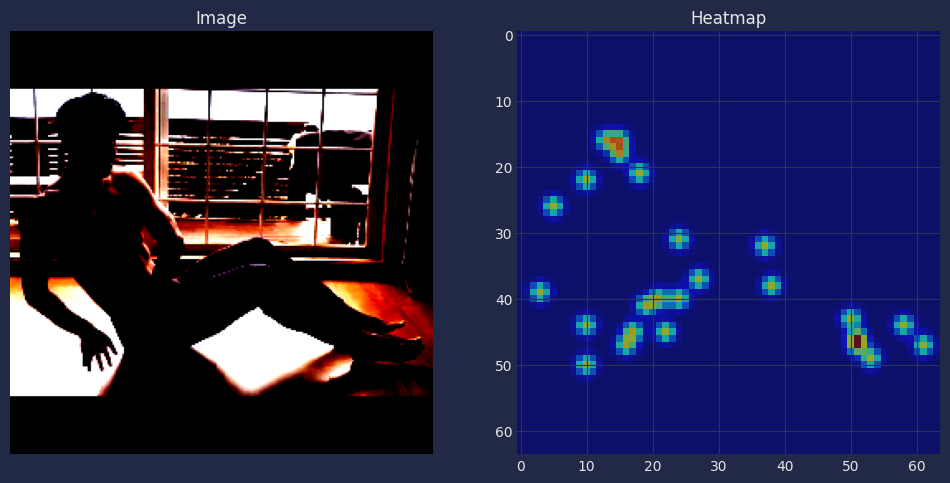

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4308496].


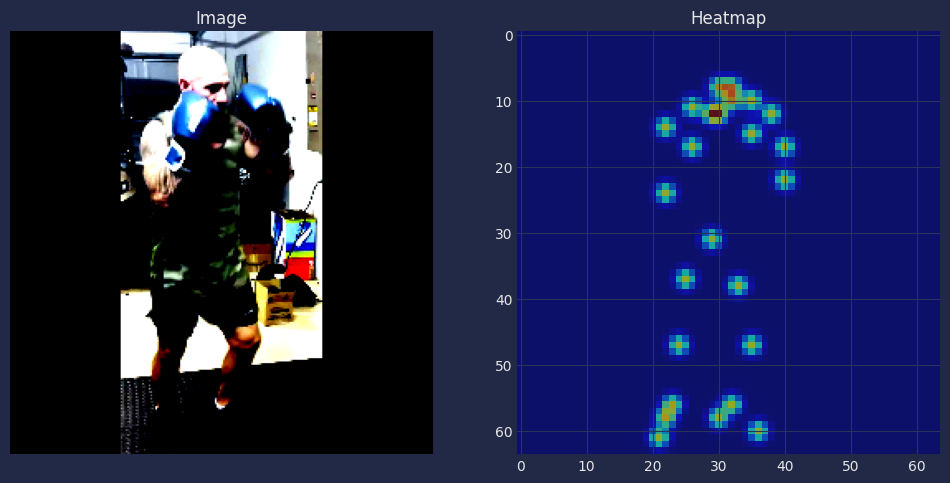

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


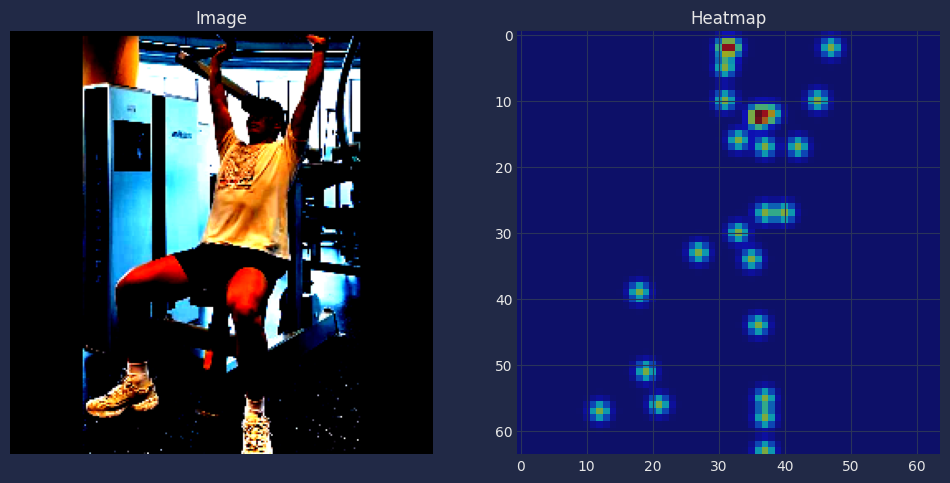

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


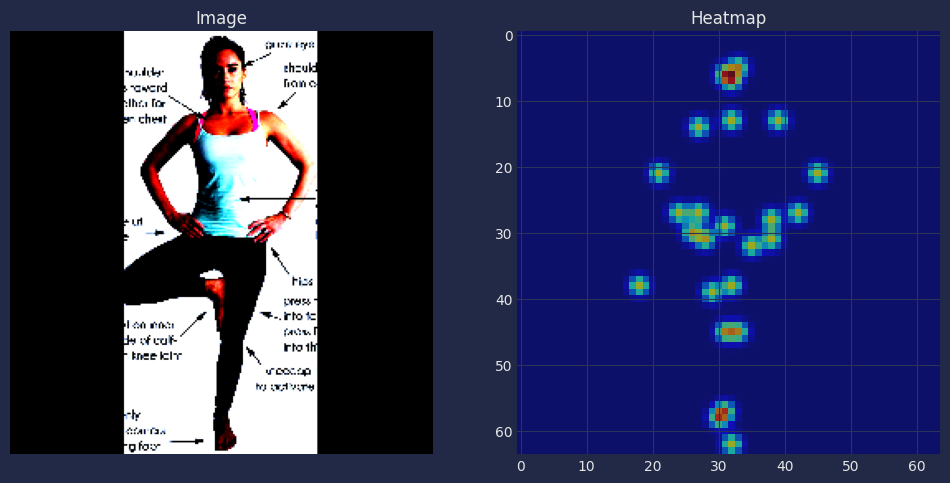

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


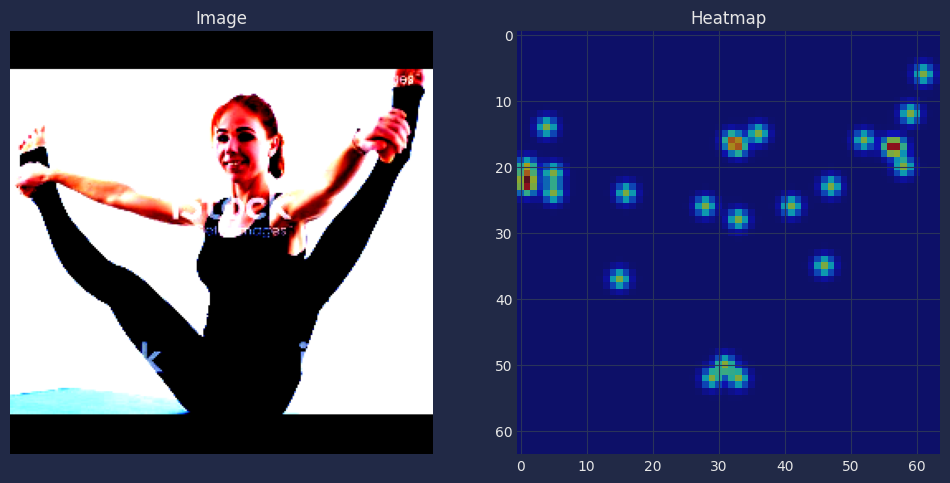

In [ ]:
def show_images_with_heatmaps_from_loader(loader, num_images=5):
    """
    Displays a specified number of images with their corresponding heatmaps from a DataLoader.

    Args:
    - loader: DataLoader that returns batches of images and heatmaps
    - num_images: Number of images to display (default is 5)
    """
    hmp = HeatmapParser()
    # Get the first batch from the DataLoader
    for images, heatmaps in loader:
        # Ensure we don't exceed the batch size
        num_images = min(num_images, images.shape[0])

        for i in range(num_images):
            image = images[i]
            heatmap = heatmaps[i]
            
            # Convert image tensor to numpy
            image_np = image.permute(1, 2, 0).numpy()  # Convert (C, H, W) -> (H, W, C)
            heatmap_np = heatmap.numpy()  # Heatmap shape: (num_kpts, H, W)

            # Sum the heatmap across all keypoints (channels) to create a combined heatmap
            combined_heatmap = np.sum(heatmap_np, axis=0)  # Shape: (H, W)

            # Plotting
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))

            # Show the image
            ax[0].imshow(image_np)
            ax[0].set_title('Image')
            ax[0].axis('off')

            # Show the combined heatmap overlayed on the image
            # ax[1].imshow(image_np, alpha=1)  # Display the image
            ax[1].imshow(combined_heatmap, cmap='jet', alpha=0.6)  # Overlay the combined heatmap
            ax[1].set_title('Heatmap')
            # ax[1].axis('off')

            plt.show()

        # Stop after the first batch
        break
    
show_images_with_heatmaps_from_loader(hgn_val_loader, num_images=5)

In [15]:
# Max pooling layer
Pool = nn.MaxPool2d

# Batch normalization layer, applied to the feature maps based on the channel dimension.
def batchnorm(x):
    return nn.BatchNorm2d(x.size()[1])(x)

# Basic convolutional block that can include batch normalization and ReLU activation.
class Conv(nn.Module):
    def __init__(self, inp_dim, out_dim, kernel_size=3, stride=1, bn=False, relu=True):
        super(Conv, self).__init__()
        # Define input channels and convolutional layer
        self.inp_dim = inp_dim
        self.conv = nn.Conv2d(inp_dim, out_dim, kernel_size, stride, padding=(kernel_size-1)//2, bias=not bn) # same padding
        
        # Conditional initialization of ReLU and BatchNorm layers
        self.relu = None
        self.bn = None
        if relu:
            self.relu = nn.ReLU()
        if bn:
            self.bn = nn.BatchNorm2d(out_dim)

    def forward(self, x):
        # Assert that input channels match the expected dimension.
        assert x.size()[1] == self.inp_dim, "Input channels don't match the expected dimension: {} {}".format(x.size()[1], self.inp_dim)
        # Apply convolution
        x = self.conv(x)
        # Apply batch normalization if specified
        if self.bn is not None:
            x = self.bn(x)
        # Apply ReLU activation if specified
        if self.relu is not None:
            x = self.relu(x)
        return x
    
# Residual block (bottleneck layer) similar to the ResNet block, consisting of convolutions, batch normalization, and ReLU.
class Residual(nn.Module):
    def __init__(self, inp_dim, out_dim):
        super(Residual, self).__init__()
        # ReLU activation used in the forward pass
        self.relu = nn.ReLU()
        
        # BatchNorm and three convolutional layers (1x1 -> 3x3 -> 1x1)
        self.bn1 = nn.BatchNorm2d(inp_dim)
        self.conv1 = Conv(inp_dim, int(out_dim/2), 1, relu=False)
        self.bn2 = nn.BatchNorm2d(int(out_dim/2))
        self.conv2 = Conv(int(out_dim/2), int(out_dim/2), 3, relu=False)
        self.bn3 = nn.BatchNorm2d(int(out_dim/2))
        self.conv3 = Conv(int(out_dim/2), out_dim, 1, relu=False)
        
        # Shortcut layer to match dimensions if the input and output channels differ.
        self.skip_layer = Conv(inp_dim, out_dim, 1, relu=False)
        # If the input and output dimensions match, no need for a skip layer.
        self.need_skip = inp_dim != out_dim
        
    def forward(self, x):
        # Apply the skip connection or pass input directly
        residual = self.skip_layer(x) if self.need_skip else x
        
        # First batch normalization and ReLU
        out = self.bn1(x)
        out = self.relu(out)
        # First convolution (1x1)
        out = self.conv1(out)
        
        # Second batch normalization and ReLU
        out = self.bn2(out)
        out = self.relu(out)
        # Second convolution (3x3)
        out = self.conv2(out)
        
        # Third batch normalization and ReLU
        out = self.bn3(out)
        out = self.relu(out)
        # Third convolution (1x1)
        out = self.conv3(out)
        
        # Add the residual (skip connection) to the output
        out += residual
        return out

# Recursive hourglass structure for feature extraction at multiple scales.
class Hourglass(nn.Module):
    def __init__(self, n, f, bn=None, increase=0):
        super(Hourglass, self).__init__()
        nf = f + increase  # Number of output channels increases as depth increases
        
        # Upper branch with a Residual block (preserves resolution)
        self.up1 = Residual(f, f)
        
        # Lower branch starts with pooling to reduce resolution
        self.pool1 = Pool(2, 2)
        self.low1 = Residual(f, nf)
        
        self.n = n  # Depth of the hourglass
        
        # Recursive call: if depth is greater than 1, instantiate another hourglass; otherwise, a simple Residual block.
        if self.n > 1:
            self.low2 = Hourglass(n-1, nf, bn=bn)
        else:
            self.low2 = Residual(nf, nf)
        
        # Residual block to bring back the resolution after recursive call
        self.low3 = Residual(nf, f)
        
        # Upsampling to return to the original resolution
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        # Upper branch
        up1  = self.up1(x)
        
        # Lower branch: downsample, apply residuals and hourglass
        pool1 = self.pool1(x)
        low1 = self.low1(pool1)
        low2 = self.low2(low1)
        low3 = self.low3(low2)
        
        # Upsample the lower branch output
        up2  = self.up2(low3)
        
        # Sum the outputs of the upper and lower branches
        return up1 + up2

class Merge(nn.Module):
    def __init__(self, x_dim, y_dim):
        super(Merge, self).__init__()
        self.conv = Conv(x_dim, y_dim, 1, relu=False, bn=False)

    def forward(self, x):
        return self.conv(x)

# Full Pose Estimation Network using multiple hourglass modules
class PoseNet(nn.Module):
    def __init__(self, nstack, inp_dim, oup_dim, bn=False, increase=0, **kwargs):
        super(PoseNet, self).__init__()
        
        self.nstack = nstack  # Number of stacked hourglass modules
        
        # Initial feature extraction layers
        self.pre = nn.Sequential(
            Conv(3, 64, 7, 2, bn=True, relu=True),  # Large conv kernel for initial downsampling
            Residual(64, 128),                     # Residual block to further process features
            Pool(2, 2),                            # Downsampling by pooling
            Residual(128, 128),                    # More residual blocks
            Residual(128, inp_dim)                 # Project features to input dimension for hourglass
        )
        
        # Stacked hourglass modules
        self.hgs = nn.ModuleList([
            nn.Sequential(
                Hourglass(4, inp_dim, bn, increase),  # 4-level hourglass
            ) for i in range(nstack)
        ])
        
        # Intermediate feature extraction after each hourglass
        self.features = nn.ModuleList([
            nn.Sequential(
                Residual(inp_dim, inp_dim),          # Residual block to refine hourglass output
                Conv(inp_dim, inp_dim, 1, bn=True, relu=True)  # 1x1 convolution
            ) for i in range(nstack)
        ])
        
        # Output prediction for each hourglass (e.g., heatmap predictions)
        self.outs = nn.ModuleList([
            Conv(inp_dim, oup_dim, 1, relu=False, bn=False)  # No activation, direct output
            for i in range(nstack)
        ])
        
        # Layers for merging features across hourglass stacks
        self.merge_features = nn.ModuleList([
            Merge(inp_dim, inp_dim) for i in range(nstack-1)
        ])
        
        # Layers for merging predictions across hourglass stacks
        self.merge_preds = nn.ModuleList([
            Merge(oup_dim, inp_dim) for i in range(nstack-1)
        ])
        

    def forward(self, imgs):
        # Reformat the input to match the channel format expected by Conv2D (N, C, H, W)
        x = imgs.permute(0, 3, 1, 2)
        # Apply the preprocessing layers
        x = self.pre(x)
        
        combined_hm_preds = []  # Store all heatmap predictions across stacks
        
        for i in range(self.nstack):
            # Pass through hourglass module
            hg = self.hgs[i](x)
            
            # Pass hourglass output through residual and conv layers
            feature = self.features[i](hg)
            
            # Get the heatmap prediction for this stack
            preds = self.outs[i](feature)
            combined_hm_preds.append(preds)
            
            # Merge features and predictions with the input for the next stack
            if i < self.nstack - 1:
                x = x + self.merge_preds[i](preds) + self.merge_features[i](feature)
        
        # Return stacked heatmap predictions
        return torch.stack(combined_hm_preds, 1)
        

    # # Loss calculation: sum the loss across all hourglass stacks
    # def calc_loss(self, combined_hm_preds, heatmaps):
    #     combined_loss = []
    #     print('combined_hm_preds:',combined_hm_preds.shape)
    #     print('heatmaps:', heatmaps.shape)
    #     expanded_heatmaps = heatmaps.unsqueeze(1).repeat(1, self.nstack, 1, 1, 1)
    #     print('expanded_heatmaps:', expanded_heatmaps.shape)
    #     for i in range(self.nstack):
            
    #         # Compare the predicted heatmaps with the target heatmaps
    #         combined_loss.append(self.heatmapLoss(combined_hm_preds[0][:, i], expanded_heatmaps[0][:,i]))
        
    #     # Stack and sum losses across all stacks
    #     combined_loss = torch.stack(combined_loss, dim=1)
    #     return combined_loss

In [16]:
# # Testing the model with a dummy input
# def test_posenet():
#     batch_size = 4
#     input_channels = 3
#     img_size = 512
#     nstack = 2
#     inp_dim = 512
#     oup_dim = 4

#     print(f"Initializing PoseNet with nstack={nstack}, inp_dim={inp_dim}, oup_dim={oup_dim}")
#     model = PoseNet(nstack=nstack, inp_dim=inp_dim, oup_dim=oup_dim, increase=16)
       
#     print("\nTesting PoseNet initialization...")
    
#     assert isinstance(model, torch.nn.Module), "Model should be an instance of nn.Module"
#     assert len(model.hgs) == nstack, f"Expected {nstack} stacks, but got {len(model.hgs)}"
#     assert len(model.features) == nstack, f"Expected {nstack} feature layers, but got {len(model.features)}"
#     assert len(model.outs) == nstack, f"Expected {nstack} output layers, but got {len(model.outs)}"
#     assert len(model.merge_features) == nstack - 1, f"Expected {nstack - 1} merge feature layers, but got {len(model.merge_features)}"
#     assert len(model.merge_preds) == nstack - 1, f"Expected {nstack - 1} merge prediction layers, but got {len(model.merge_preds)}"
    
#     print("Model structure tests passed.")
    
#     print(f"\nCreating dummy input with shape: ({batch_size}, {img_size}, {img_size}, {input_channels})")
#     x = torch.randn(batch_size, img_size, img_size, input_channels) # (N,H,W,C)
#     x = x.permute(0, 3, 1, 2)
    
#     print("\nTesting forward pass...")
#     try:
#         with torch.no_grad():
#             # Check output of pre layer
#             pre_output = model.pre(x)
#             print(f"Shape after pre layer: {pre_output.shape}")
            
#             # Check output of first hourglass
#             hg_output = model.hgs[0](pre_output)
#             print(f"Shape after first hourglass: {hg_output.shape}")
            
#             # Check output of first feature layer
#             feature_output = model.features[0](hg_output)
#             print(f"Shape after first feature layer: {feature_output.shape}")
            
#             # Full forward pass
#             x = torch.randn(batch_size, img_size, img_size, input_channels) # (N,H,W,C)
#             output = model(x)
        
#         expected_shape = (batch_size, nstack, oup_dim, img_size // 4, img_size // 4)
#         assert output.shape == expected_shape, f"Expected output shape {expected_shape}, but got {output.shape}"
#         assert not torch.isnan(output).any(), "Output contains NaN values"
#         assert not torch.all(output == 0), "Output is all zeros"
#         print("Forward pass tests passed.")
#     except Exception as e:
#         print(f"Error during forward pass: {str(e)}")
#         print("Last successful shape:", locals().get('pre_output', locals().get('hg_output', locals().get('feature_output', x))).shape)
#         raise

#     print("\nAll tests passed successfully!")

# # Run the test
# test_posenet()

In [17]:
hgn = PoseNet(nstack=CONFIG['NUM_STACKS'], inp_dim=CONFIG['IM_SIZE'], oup_dim=CONFIG['NUM_KEYPOINTS'], increase=0).cuda()

summary(hgn, input_size=(CONFIG['BATCH_SIZE'], 256, 256, 3))

Layer (type:depth-idx)                                       Output Shape              Param #
PoseNet                                                      [16, 8, 25, 64, 64]       --
├─Sequential: 1-1                                            [16, 256, 64, 64]         --
│    └─Conv: 2-1                                             [16, 64, 128, 128]        --
│    │    └─Conv2d: 3-1                                      [16, 64, 128, 128]        9,408
│    │    └─BatchNorm2d: 3-2                                 [16, 64, 128, 128]        128
│    │    └─ReLU: 3-3                                        [16, 64, 128, 128]        --
│    └─Residual: 2-2                                         [16, 128, 128, 128]       --
│    │    └─Conv: 3-4                                        [16, 128, 128, 128]       8,320
│    │    └─BatchNorm2d: 3-5                                 [16, 64, 128, 128]        128
│    │    └─ReLU: 3-6                                        [16, 64, 128, 128]        

In [20]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=4, reduction='mean'):
        """
        Focal Loss for heatmap-based keypoint detection.

        Args:
        - alpha: Scaling factor for the positive class
        - gamma: Focusing parameter to reduce easy-to-classify examples' importance
        - reduction: How to reduce the loss ('mean' or 'sum')
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Apply softmax to the predicted heatmap to normalize predictions
        inputs = torch.softmax(inputs, dim=-1)
        
        # Manual binary cross-entropy calculation:
        epsilon = 1e-8  # to avoid log(0)
        inputs = inputs.clamp(min=epsilon, max=1. - epsilon)  # Clamping values to avoid log(0)
        
        # BCE: -[y * log(p) + (1 - y) * log(1 - p)]
        bce_loss = -(targets * torch.log(inputs) + (1 - targets) * torch.log(1 - inputs))
        
        # Compute the focal loss
        pt = torch.exp(-bce_loss)  # pt is the predicted probability of the true class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss

        # Reduce the loss (mean or sum across the batch)
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [ ]:
optimizer = torch.optim.Adam(hgn.parameters(), lr=1e-3)

criterion = nn.MSELoss()

# criterion = FocalLoss(alpha=1, gamma=2, reduction='mean')

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', threshold=1e-3, factor=0.1, patience=15, min_lr=1e-6)

dataloaders = {'TRAIN': hgn_train_loader, 'VAL': hgn_val_loader}

## YOLOv8 nano Pose

In [27]:
yolov8_model = YOLO('yolov8n-pose.pt')

100%|██████████| 6.52M/6.52M [00:00<00:00, 9.28MB/s]


In [28]:
yolov8_model.info()

YOLOv8n-pose summary: 250 layers, 3,295,470 parameters, 0 gradients, 9.3 GFLOPs


(250, 3295470, 0, 9.2959952)

## Keypoint RCNN

In [6]:
# Custom dataset to load the images, and keypoints then generate heatmaps for hourglass network using a yolov8 dataset
class RCNNYOLOv8KptsDataset(Dataset):
    def __init__(self, config, transforms, split):
        """
        Initializes the dataset based on the split.
        
        Args:
            config_path (str): Path to the YAML configuration file.
            split (str): The split to load ('train', 'val', 'test').
        """
        # Load dataset config file
        ds_config_path = os.path.join(config['DATASET_DIR'], 'data.yaml')
        try:
            with open(ds_config_path, 'r') as file:
                ds_config = yaml.safe_load(file)
        except Exception as e:
            raise e
        self.config = config
        self.num_keypoints = self.config['NUM_KEYPOINTS']
        self.img_dir = os.path.join(ds_config['path'], split, 'images')
        self.label_dir = self.img_dir.replace('images', 'labels')
        self.img_list = os.listdir(self.img_dir)
        self.label_list = os.listdir(self.label_dir)
        self.transforms = transforms
            
        # Define directory paths based on split
        self.split = split.lower()
        assert self.split in ['train', 'val', 'valid', 'validation', 'test'], "Split must be one of 'train', 'val', 'test'"
                
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_list[idx])
        label_path = os.path.join(self.label_dir, self.label_list[idx])
        
        img = np.array(Image.open(img_path).convert("RGB")) / 255.0
        img_height, img_width = img.shape[:2]

        keypoints, cls_ids, bboxes = self.loadLabel(label_path, img_height, img_width)
        transforms = self.transforms
        
        aug_labels = []
        aug_bboxes = []
        aug_keypoints_with_vis = []
        # Loop through each object and apply the transformation
        for i in range(len(bboxes)):
            obj_keypoints = keypoints[i]
            xy_keypoints = [kpt[:2] for kpt in obj_keypoints]
            vis = [kpt[2] for kpt in obj_keypoints]
            # Apply the transformation
            augments = transforms(image=img, bboxes=[bboxes[i]], keypoints=xy_keypoints, labels=[cls_ids[i]])
            # Re-adding visibility flag after transformation
            vis_kpts = [[kp[0], kp[1], vis[idx]] for idx, kp in enumerate(augments['keypoints'])]
            aug_bboxes.append(augments['bboxes'][0])
            aug_labels.append(augments['labels'][0])
            aug_keypoints_with_vis.append(vis_kpts)

        # Create the dictionary for this object
        augmented_targets = {
            'boxes': torch.tensor(aug_bboxes),
            'keypoints': torch.tensor(aug_keypoints_with_vis),
            'labels': torch.tensor(aug_labels)
        }

        img = augments['image']

        return img, augmented_targets
    
    def loadLabel(self, label_path, img_height, img_width):
        """
        Parse the label data, denormalize the coordinates, and return in the required format.

        Args:
            label_path (str): The path of the label file.
            img_width (int): Width of the image.
            img_height (int): Height of the image.

        Returns:
            keypoints (np.array): Array of shape (n, k, 3) containing [x, y, v] for each keypoint for each object.
            cls_id (np.array): Array of shape (n,) containing [class_id,] for each object.
            bbox (np.array): Array of shape (n,4) containing [x_min, y_min, x_max, y_max] for each object.
        """
        with open(label_path, 'r') as lbl:
            lines = lbl.readlines()
        
        keypoints = []  # This will hold keypoints for each object
        bboxes = []     # This will hold bboxes for each object
        cls_ids = []    # This will hold class IDs for each object
        
        if lines:
            for line in lines:
                line = line.strip().split()
                
                class_id = int(line[0]) + 1
                x_center = float(line[1]) * img_width  # Denormalize x_center
                y_center = float(line[2]) * img_height # Denormalize y_center
                width = float(line[3]) * img_width     # Denormalize width
                height = float(line[4]) * img_height   # Denormalize height
                x_min = x_center - width / 2
                y_min = y_center - height / 2
                x_max = x_center + width / 2
                y_max = y_center + height / 2
                
                # Add the bbox in (x_min, y_min, x_max, y_max) format
                bbox = [int(x_min), int(y_min), int(x_max), int(y_max)]
                bboxes.append(bbox)
                cls_ids.append(class_id)
                
                # Parse keypoints for this object
                object_keypoints = []  # Keypoints for a single object
                for j in range(self.num_keypoints):
                    x = np.clip(int(float(line[5 + 3*j]) * img_width), 0, img_width - 1)  # Denormalize x and clamp
                    y = np.clip(int(float(line[6 + 3*j]) * img_height), 0, img_height - 1)  # Denormalize y and clamp
                    visibility = int(line[7 + 3*j])  # Visibility flag (0 or 1)
                    
                    # Append the keypoint as [x, y, visibility]
                    object_keypoints.append([x, y, visibility])
                
                # Add keypoints for the current object to the keypoints list
                keypoints.append(object_keypoints)
            
        else:
            # Return empty arrays if no lines were found
            return (np.zeros(shape=(1, self.config['NUM_KEYPOINTS'], 3)), 
                    np.zeros(shape=(1,)),
                    np.array([[1, 2, 3, 4]]))

        # Convert lists to numpy arrays and return
        return (
            np.array(keypoints),  # Shape: (n_objects, num_keypoints, 3)
            np.array(cls_ids),    # Shape: (n_objects,)
            np.array(bboxes)      # Shape: (n_objects, 4)
        )

In [7]:
rcnn_train_transforms =  A.Compose([
            # A.RandomSizedBBoxSafeCrop(height=CONFIG['IM_SIZE'], 
            #                                 width=CONFIG['IM_SIZE'], 
            #                                 erosion_rate=0.2),  # Mimics the effect of cropping with IoU safety
            A.HorizontalFlip(p=0.5),  # Flips the image and keypoints
            A.Rotate(limit=45, p=0.5, border_mode=0, value=0),  # Rotates image and keypoints
            A.RandomBrightnessContrast(p=0.2),  # Adjusts brightness and contrast
            # A.LongestMaxSize(max_size=CONFIG['IM_SIZE']),
            # A.PadIfNeeded(min_height=CONFIG['IM_SIZE'], 
            #                 min_width=CONFIG['IM_SIZE'], 
            #                 border_mode=0, 
            #                 value=0),  # Pad to maintain aspect ratio
            ToTensorV2(),  # Convert to tensor
        ],
        keypoint_params=A.KeypointParams(format='xy', remove_invisible=False),
        bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
    )

rcnn_val_test_transforms = A.Compose([
            # A.LongestMaxSize(max_size=CONFIG['IM_SIZE']),
            # A.PadIfNeeded(min_height=CONFIG['IM_SIZE'], min_width=CONFIG['IM_SIZE'], border_mode=0, value=0),
            ToTensorV2(),
            ],
            keypoint_params=A.KeypointParams(format='xy', remove_invisible=False),
            bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
            )
    
rcnn_preprocess_transforms = A.Compose([
            # A.LongestMaxSize(max_size=CONFIG['IM_SIZE']),
            # A.PadIfNeeded(min_height=CONFIG['IM_SIZE'], min_width=CONFIG['IM_SIZE'], border_mode=0, value=0),
            ToTensorV2(),
            ],
            keypoint_params=A.KeypointParams(format='xy', remove_invisible=False),
            bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
            )

/opt/conda/envs/pingpong/lib/python3.10/site-packages/albumentations/core/composition.py:191: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
/opt/conda/envs/pingpong/lib/python3.10/site-packages/albumentations/core/composition.py:191: UserWarning: Got processor for keypoints, but no transform to process it.
  self._set_keys()


In [8]:
def custom_collate_fn(batch):
    images, targets = tuple(zip(*batch))
    return images, targets

In [9]:
# Instantiate the datasets and loaders
rcnn_train_dataset = RCNNYOLOv8KptsDataset(config=CONFIG, transforms=rcnn_train_transforms, split='train')
rcnn_val_dataset = RCNNYOLOv8KptsDataset(config=CONFIG, transforms=rcnn_val_test_transforms, split='valid')
rcnn_test_dataset = RCNNYOLOv8KptsDataset(config=CONFIG, transforms=rcnn_val_test_transforms, split='valid')
rcnn_train_loader = DataLoader(rcnn_train_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, pin_memory=CONFIG['PIN_MEMORY'], num_workers=CONFIG['NUM_WORKERS'], collate_fn=custom_collate_fn)
rcnn_val_loader = DataLoader(rcnn_val_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, pin_memory=CONFIG['PIN_MEMORY'], num_workers=CONFIG['NUM_WORKERS'], collate_fn=custom_collate_fn)
rcnn_test_loader = DataLoader(rcnn_test_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, pin_memory=CONFIG['PIN_MEMORY'], num_workers=CONFIG['NUM_WORKERS'], collate_fn=custom_collate_fn)

In [10]:
for batch_images, batch_targets in rcnn_train_loader:
    # print(batch_targets)
    print(batch_targets[0]['keypoints'].shape)
    print(batch_targets[0]['boxes'].shape)
    print(batch_targets[0]['labels'].shape)
    break

torch.Size([1, 25, 3])
torch.Size([1, 4])
torch.Size([1])


In [11]:
# Load the pre-trained model
rcnn_weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT
rcnn_model = torchvision.models.detection.keypointrcnn_resnet50_fpn(weights=rcnn_weights)
# rcnn_model = torchvision.models.detection.keypointrcnn_resnet50_fpn()

# Freeze the backbone (feature extractor)
# for param in rcnn_model.backbone.parameters():
#     param.requires_grad = False
in_features = rcnn_model.roi_heads.keypoint_predictor.kps_score_lowres.in_channels
new_keypoint_predictor = KeypointRCNNPredictor(in_features, CONFIG['NUM_KEYPOINTS'])
rcnn_model.roi_heads.keypoint_predictor = new_keypoint_predictor
rcnn_model.name = 'keypointrcnn_resnet50_fpn'

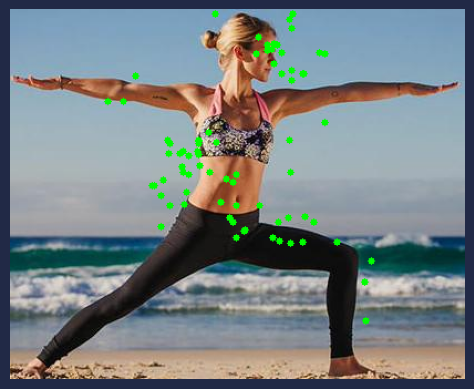

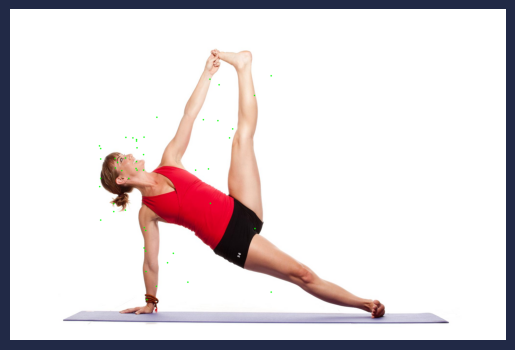

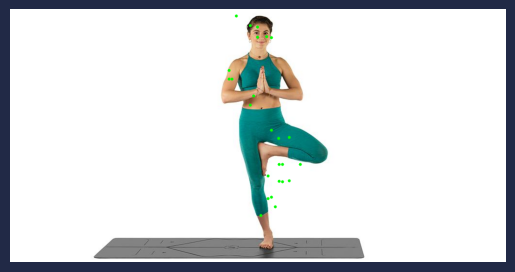

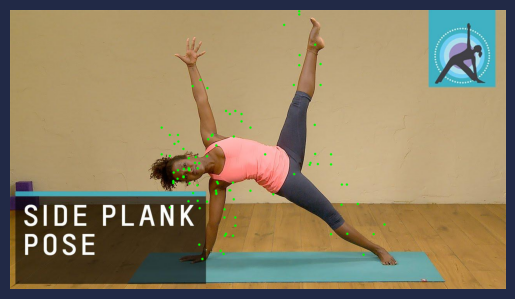

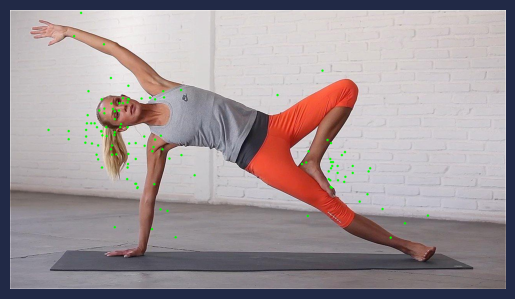

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

def visualize_keypoints_from_rcnn_loader(model, loader, num_images, device):
    """
    Visualizes the keypoints on the images.

    Args:
        model: The trained Keypoint R-CNN model.
        loader: DataLoader for loading images and targets.
        num_images (int): Number of images to visualize.
        device: Device to run the model on (CPU or GPU).
    """
    images_collected = []
    model.float().eval().to(device)
    
    for batch_images, batch_targets in loader:
        for image in batch_images:
            if len(images_collected) >= num_images:
                break
            images_collected.append(image)
            
        if len(images_collected) >= num_images:
            break
    
    # Process each image individually
    with torch.no_grad():
        outputs = []
        for image in images_collected:
            # Add batch dimension and send to device
            image = image.unsqueeze(0).to(device).float()  # Add batch dimension
            output = model(image)  # Forward pass
            outputs.append(output)
    
    # Now visualize the results
    for idx, (image, output) in enumerate(zip(images_collected, outputs)):
        # Prepare image for visualization
        image = image.detach().cpu().numpy().transpose(1, 2, 0)
        image = (image * 255).astype(np.uint8)  # Scale to 0-255 range
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        keypoints = output[0]['keypoints'].cpu().numpy()  # Assuming output is a list of dictionaries
        
        # Loop over keypoints and draw them
        for keypoint_set in keypoints:
            for (x, y, v) in keypoint_set:
                if v > 0:  # Only draw visible keypoints
                    cv2.circle(image, (int(x), int(y)), radius=3, color=(0, 255, 0), thickness=-1)

        # Display the image with keypoints
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

# Usage
visualize_keypoints_from_rcnn_loader(rcnn_model, rcnn_test_loader, 5, device)

In [13]:
params = [p for p in rcnn_model.parameters() if p.requires_grad]
all_params = [p for p in rcnn_model.parameters()]
print(len(params))
print(len(all_params))

90
101


In [14]:
params = [p for p in rcnn_model.parameters() if p.requires_grad]
lr = 5e-4
optimizer = torch.optim.AdamW(params, lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                   max_lr=lr, 
                                                   total_steps=CONFIG['NUM_EPOCHS']*len(rcnn_train_loader))
dataloaders = {'TRAIN': rcnn_train_loader, 'VAL': rcnn_val_loader}

In [14]:
# summary(rcnn_model, input_size=(1, 3, 1080, 256))

Layer (type:depth-idx)                                  Output Shape              Param #
KeypointRCNN                                            [0, 4]                    --
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 1344, 320]         --
├─BackboneWithFPN: 1-2                                  [1, 256, 21, 5]           --
│    └─IntermediateLayerGetter: 2-1                     [1, 2048, 42, 10]         --
│    │    └─Conv2d: 3-1                                 [1, 64, 672, 160]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [1, 64, 672, 160]         --
│    │    └─ReLU: 3-3                                   [1, 64, 672, 160]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 336, 80]          --
│    │    └─Sequential: 3-5                             [1, 256, 336, 80]         (212,992)
│    │    └─Sequential: 3-6                             [1, 512, 168, 40]         1,212,416
│    │    └─Sequential: 3-7              

In [15]:
for batch_images, batch_targets in rcnn_train_loader:
    batch_images = [image.float().to(device) for image in batch_images]
    batch_targets = [
                    {key: value.to(device) for key, value in target.items()}
                    for target in batch_targets
                ]
    rcnn_model.eval()
    out = rcnn_model(batch_images)
    print(out[0]['keypoints'].shape)
    print(out[0]['boxes'].shape)
    print(out[0]['labels'].shape)
    # print(out)
    break

torch.Size([2, 25, 3])
torch.Size([2, 4])
torch.Size([2])


# Training

In [16]:
def save_metrics(metrics, save_path='metrics.pkl'):
    """
    Save metrics to a file.

    Args:
    - metrics: Dictionary containing metrics to save
    - save_path: Path to save the metrics file
    """
    with open(save_path, 'wb') as f:
        pickle.dump(metrics, f)

## Hourglass network from scratch

In [23]:
def train_model(model, config, criterion, optimizer, dataloaders, scheduler=None,
                num_epochs=25, device='cuda', patience=15):
    since = time.time()
    best_model_wts = deepcopy(model.state_dict())
    best_mAP = 0.0
    no_improve = 0
    dataset_sizes = {phase: len(dataloaders[phase].dataset) for phase in ['TRAIN', 'VAL']}
    
    metrics = {'train_loss': [], 'val_loss': [],
               'train_mPCK': [], 'train_PCK_extracts': [],
               'val_mPCK': [], 'val_PCK_extracts': [],
               'train_mAP': [], 'val_mAP': []}

    heatmap_parser = HeatmapParser()
    
    oks_calc = OKSCalculator(config['SIGMAS'])

    scaler = torch.amp.GradScaler(enabled=True)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 10)

        for phase in ['TRAIN', 'VAL']:
            if phase == 'TRAIN':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            mPCKs = []
            all_oks_scores = []
            
            for inputs, labels, areas in tqdm(dataloaders[phase], desc=phase.capitalize()):
                orig_inputs = inputs.numpy()
                inputs = inputs.to(device)
                labels = labels.to(device)
                areas = areas.numpy()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'TRAIN'):
                    with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    if phase == 'TRAIN':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                
                outputs = outputs.detach().cpu().numpy()
                parsed_preds = heatmap_parser.parse(outputs)

                labels = labels.detach().cpu().numpy()
                parsed_labels = heatmap_parser.parse(labels)

                # Calculate PCK
                mPCK, extracted = compute_pck(orig_inputs, parsed_preds['loc_k'], parsed_labels['loc_k'], extract=[0.001])
                mPCKs.append(mPCK)
                
                # Calculate OKS
                oks_scores = oks_calc.compute_oks(parsed_preds['loc_k'], parsed_labels['loc_k'], areas)
                all_oks_scores.extend(oks_scores)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_mPCK = np.mean(mPCKs)
            
            # Calculate AP and mAP
            ap_results = compute_ap(all_oks_scores)
            epoch_mAP = ap_results['mAP']

            if phase == 'TRAIN' and scheduler:
                scheduler.step(metrics=epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f} mPCK: {epoch_mPCK:.4f}, mAP: {epoch_mAP:.4f}')
            # Log metrics
            metrics[f'{phase.lower()}_loss'].append(epoch_loss)
            metrics[f'{phase.lower()}_mPCK'].append(epoch_mPCK)
            metrics[f'{phase.lower()}_mAP'].append(epoch_mAP)
            if phase == 'TRAIN':
                metrics['train_PCK_extracts'].append(extracted)
            else:
                metrics['val_PCK_extracts'].append(extracted)

            if phase == 'VAL' and epoch_mAP > best_mAP:
                best_mAP = epoch_mAP
                best_model_wts = deepcopy(model.state_dict())
                no_improve = 0
            elif phase == 'VAL':
                no_improve += 1

        if no_improve >= patience:
            print(f"Early stopping triggered after epoch {epoch + 1}")
            break

    time_elapsed = time.time() - since
    print(f"Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val mAP: {best_mAP:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics

In [24]:
hgn_trained_model, metrics = train_model(hgn, CONFIG, criterion, optimizer, dataloaders, scheduler=scheduler,
                num_epochs=CONFIG['NUM_EPOCHS'], device='cuda', patience=35)

Epoch 1/1000
----------


Train: 100%|██████████| 99/99 [00:26<00:00,  3.73it/s]


TRAIN Loss: 0.0065 mPCK: 0.0008, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.54it/s]


VAL Loss: 0.0008 mPCK: 0.0022, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 2/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.88it/s]


TRAIN Loss: 0.0008 mPCK: 0.0034, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.58it/s]


VAL Loss: 0.0008 mPCK: 0.0036, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 3/1000
----------


Train: 100%|██████████| 99/99 [00:26<00:00,  3.73it/s]


TRAIN Loss: 0.0008 mPCK: 0.0046, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.49it/s]


VAL Loss: 0.0008 mPCK: 0.0055, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 4/1000
----------


Train: 100%|██████████| 99/99 [00:26<00:00,  3.77it/s]


TRAIN Loss: 0.0008 mPCK: 0.0060, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.47it/s]


VAL Loss: 0.0008 mPCK: 0.0063, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 5/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.85it/s]


TRAIN Loss: 0.0008 mPCK: 0.0071, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


VAL Loss: 0.0008 mPCK: 0.0089, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 6/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.90it/s]


TRAIN Loss: 0.0008 mPCK: 0.0088, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.55it/s]


VAL Loss: 0.0008 mPCK: 0.0118, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 7/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.82it/s]


TRAIN Loss: 0.0008 mPCK: 0.0115, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.21it/s]


VAL Loss: 0.0008 mPCK: 0.0139, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 8/1000
----------


Train: 100%|██████████| 99/99 [00:26<00:00,  3.74it/s]


TRAIN Loss: 0.0008 mPCK: 0.0145, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.25it/s]


VAL Loss: 0.0008 mPCK: 0.0181, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 9/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.85it/s]


TRAIN Loss: 0.0008 mPCK: 0.0181, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


VAL Loss: 0.0008 mPCK: 0.0217, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 10/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.93it/s]


TRAIN Loss: 0.0008 mPCK: 0.0231, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.58it/s]


VAL Loss: 0.0008 mPCK: 0.0261, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 11/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.81it/s]


TRAIN Loss: 0.0008 mPCK: 0.0269, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.58it/s]


VAL Loss: 0.0008 mPCK: 0.0300, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 12/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.84it/s]


TRAIN Loss: 0.0008 mPCK: 0.0310, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.42it/s]


VAL Loss: 0.0008 mPCK: 0.0349, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 13/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.85it/s]


TRAIN Loss: 0.0008 mPCK: 0.0358, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.37it/s]


VAL Loss: 0.0008 mPCK: 0.0402, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 14/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.85it/s]


TRAIN Loss: 0.0008 mPCK: 0.0418, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


VAL Loss: 0.0008 mPCK: 0.0466, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 15/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.85it/s]


TRAIN Loss: 0.0008 mPCK: 0.0466, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.60it/s]


VAL Loss: 0.0008 mPCK: 0.0528, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 16/1000
----------


Train: 100%|██████████| 99/99 [00:26<00:00,  3.70it/s]


TRAIN Loss: 0.0007 mPCK: 0.0544, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.29it/s]


VAL Loss: 0.0007 mPCK: 0.0592, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 17/1000
----------


Train: 100%|██████████| 99/99 [00:26<00:00,  3.80it/s]


TRAIN Loss: 0.0007 mPCK: 0.0614, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.35it/s]


VAL Loss: 0.0007 mPCK: 0.0736, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 18/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.87it/s]


TRAIN Loss: 0.0007 mPCK: 0.0714, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


VAL Loss: 0.0008 mPCK: 0.0750, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 19/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.94it/s]


TRAIN Loss: 0.0007 mPCK: 0.0803, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


VAL Loss: 0.0007 mPCK: 0.0830, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 20/1000
----------


Train: 100%|██████████| 99/99 [00:26<00:00,  3.78it/s]


TRAIN Loss: 0.0007 mPCK: 0.0869, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.10it/s]


VAL Loss: 0.0007 mPCK: 0.0977, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 21/1000
----------


Train: 100%|██████████| 99/99 [00:26<00:00,  3.78it/s]


TRAIN Loss: 0.0007 mPCK: 0.0977, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.09it/s]


VAL Loss: 0.0007 mPCK: 0.1054, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 22/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.90it/s]


TRAIN Loss: 0.0007 mPCK: 0.1022, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.36it/s]


VAL Loss: 0.0007 mPCK: 0.1071, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 23/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.83it/s]


TRAIN Loss: 0.0007 mPCK: 0.1095, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.39it/s]


VAL Loss: 0.0007 mPCK: 0.1160, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 24/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.92it/s]


TRAIN Loss: 0.0007 mPCK: 0.1173, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.35it/s]


VAL Loss: 0.0007 mPCK: 0.1240, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 25/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.90it/s]


TRAIN Loss: 0.0007 mPCK: 0.1251, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.44it/s]


VAL Loss: 0.0007 mPCK: 0.1279, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 26/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.85it/s]


TRAIN Loss: 0.0007 mPCK: 0.1336, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.17it/s]


VAL Loss: 0.0007 mPCK: 0.1248, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 27/1000
----------


Train: 100%|██████████| 99/99 [00:41<00:00,  2.39it/s]


TRAIN Loss: 0.0007 mPCK: 0.1449, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:02<00:00,  4.07it/s]


VAL Loss: 0.0007 mPCK: 0.1377, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 28/1000
----------


Train: 100%|██████████| 99/99 [00:40<00:00,  2.45it/s]


TRAIN Loss: 0.0007 mPCK: 0.1540, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.30it/s]


VAL Loss: 0.0007 mPCK: 0.1336, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 29/1000
----------


Train: 100%|██████████| 99/99 [00:32<00:00,  3.02it/s]


TRAIN Loss: 0.0007 mPCK: 0.1597, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:02<00:00,  4.16it/s]


VAL Loss: 0.0007 mPCK: 0.1331, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 30/1000
----------


Train: 100%|██████████| 99/99 [00:41<00:00,  2.39it/s]


TRAIN Loss: 0.0007 mPCK: 0.1618, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:02<00:00,  4.12it/s]


VAL Loss: 0.0007 mPCK: 0.1486, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 31/1000
----------


Train: 100%|██████████| 99/99 [00:41<00:00,  2.38it/s]


TRAIN Loss: 0.0007 mPCK: 0.1770, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:02<00:00,  4.13it/s]


VAL Loss: 0.0007 mPCK: 0.1571, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 32/1000
----------


Train: 100%|██████████| 99/99 [00:28<00:00,  3.51it/s]


TRAIN Loss: 0.0007 mPCK: 0.1847, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.28it/s]


VAL Loss: 0.0007 mPCK: 0.1689, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 33/1000
----------


Train: 100%|██████████| 99/99 [00:38<00:00,  2.58it/s]


TRAIN Loss: 0.0006 mPCK: 0.1921, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


VAL Loss: 0.0007 mPCK: 0.1591, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 34/1000
----------


Train: 100%|██████████| 99/99 [00:41<00:00,  2.39it/s]


TRAIN Loss: 0.0006 mPCK: 0.2007, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:02<00:00,  4.15it/s]


VAL Loss: 0.0007 mPCK: 0.1633, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 35/1000
----------


Train: 100%|██████████| 99/99 [00:41<00:00,  2.40it/s]


TRAIN Loss: 0.0006 mPCK: 0.2122, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.24it/s]


VAL Loss: 0.0007 mPCK: 0.1653, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 36/1000
----------


Train: 100%|██████████| 99/99 [00:30<00:00,  3.22it/s]


TRAIN Loss: 0.0006 mPCK: 0.2190, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


VAL Loss: 0.0007 mPCK: 0.1707, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 37/1000
----------


Train: 100%|██████████| 99/99 [00:42<00:00,  2.35it/s]


TRAIN Loss: 0.0006 mPCK: 0.2220, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


VAL Loss: 0.0007 mPCK: 0.1746, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 38/1000
----------


Train: 100%|██████████| 99/99 [00:36<00:00,  2.68it/s]


TRAIN Loss: 0.0006 mPCK: 0.2336, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.63it/s]


VAL Loss: 0.0007 mPCK: 0.1867, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 39/1000
----------


Train: 100%|██████████| 99/99 [00:26<00:00,  3.75it/s]


TRAIN Loss: 0.0006 mPCK: 0.2469, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:02<00:00,  4.13it/s]


VAL Loss: 0.0007 mPCK: 0.1952, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 40/1000
----------


Train: 100%|██████████| 99/99 [00:37<00:00,  2.61it/s]


TRAIN Loss: 0.0005 mPCK: 0.2602, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:02<00:00,  4.18it/s]


VAL Loss: 0.0007 mPCK: 0.1990, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 41/1000
----------


Train: 100%|██████████| 99/99 [00:34<00:00,  2.89it/s]


TRAIN Loss: 0.0005 mPCK: 0.2760, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.47it/s]


VAL Loss: 0.0006 mPCK: 0.2119, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 42/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.90it/s]


TRAIN Loss: 0.0005 mPCK: 0.2932, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.27it/s]


VAL Loss: 0.0007 mPCK: 0.2150, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 43/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.86it/s]


TRAIN Loss: 0.0005 mPCK: 0.3056, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.24it/s]


VAL Loss: 0.0007 mPCK: 0.2124, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 44/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.85it/s]


TRAIN Loss: 0.0005 mPCK: 0.3219, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.64it/s]


VAL Loss: 0.0006 mPCK: 0.2299, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 45/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.92it/s]


TRAIN Loss: 0.0005 mPCK: 0.3384, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


VAL Loss: 0.0007 mPCK: 0.2195, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 46/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.93it/s]


TRAIN Loss: 0.0004 mPCK: 0.3522, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.55it/s]


VAL Loss: 0.0006 mPCK: 0.2241, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 47/1000
----------


Train: 100%|██████████| 99/99 [00:24<00:00,  3.97it/s]


TRAIN Loss: 0.0004 mPCK: 0.3653, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.59it/s]


VAL Loss: 0.0006 mPCK: 0.2302, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 48/1000
----------


Train: 100%|██████████| 99/99 [00:24<00:00,  3.98it/s]


TRAIN Loss: 0.0004 mPCK: 0.3826, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.63it/s]


VAL Loss: 0.0006 mPCK: 0.2302, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 49/1000
----------


Train: 100%|██████████| 99/99 [00:26<00:00,  3.71it/s]


TRAIN Loss: 0.0004 mPCK: 0.3937, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.10it/s]


VAL Loss: 0.0006 mPCK: 0.2312, Extracted PCKs: {'PCK@0.001': 0.0125}
Epoch 50/1000
----------


Train: 100%|██████████| 99/99 [00:28<00:00,  3.51it/s]


TRAIN Loss: 0.0003 mPCK: 0.4091, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.14it/s]


VAL Loss: 0.0007 mPCK: 0.2316, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 51/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.95it/s]


TRAIN Loss: 0.0003 mPCK: 0.4177, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


VAL Loss: 0.0007 mPCK: 0.2381, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 52/1000
----------


Train: 100%|██████████| 99/99 [00:24<00:00,  3.96it/s]


TRAIN Loss: 0.0003 mPCK: 0.4291, Extracted PCKs: {'PCK@0.001': 0.0125}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


VAL Loss: 0.0006 mPCK: 0.2388, Extracted PCKs: {'PCK@0.001': 0.004166666666666667}
Epoch 53/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.85it/s]


TRAIN Loss: 0.0003 mPCK: 0.4454, Extracted PCKs: {'PCK@0.001': 0.0375}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.47it/s]


VAL Loss: 0.0006 mPCK: 0.2445, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 54/1000
----------


Train: 100%|██████████| 99/99 [00:26<00:00,  3.77it/s]


TRAIN Loss: 0.0003 mPCK: 0.4615, Extracted PCKs: {'PCK@0.001': 0.05625}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.53it/s]


VAL Loss: 0.0006 mPCK: 0.2444, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 55/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.88it/s]


TRAIN Loss: 0.0003 mPCK: 0.4861, Extracted PCKs: {'PCK@0.001': 0.025}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


VAL Loss: 0.0006 mPCK: 0.2622, Extracted PCKs: {'PCK@0.001': 0.0375}
Epoch 56/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.91it/s]


TRAIN Loss: 0.0002 mPCK: 0.5060, Extracted PCKs: {'PCK@0.001': 0.0875}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.70it/s]


VAL Loss: 0.0006 mPCK: 0.2580, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 57/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.90it/s]


TRAIN Loss: 0.0004 mPCK: 0.3973, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.53it/s]


VAL Loss: 0.0006 mPCK: 0.1919, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 58/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.91it/s]


TRAIN Loss: 0.0003 mPCK: 0.4384, Extracted PCKs: {'PCK@0.001': 0.0}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.45it/s]


VAL Loss: 0.0006 mPCK: 0.2429, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 59/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.91it/s]


TRAIN Loss: 0.0002 mPCK: 0.5088, Extracted PCKs: {'PCK@0.001': 0.0625}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


VAL Loss: 0.0006 mPCK: 0.2557, Extracted PCKs: {'PCK@0.001': 0.04583333333333333}
Epoch 60/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.91it/s]


TRAIN Loss: 0.0002 mPCK: 0.5429, Extracted PCKs: {'PCK@0.001': 0.11875}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.58it/s]


VAL Loss: 0.0006 mPCK: 0.2580, Extracted PCKs: {'PCK@0.001': 0.04583333333333333}
Epoch 61/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.92it/s]


TRAIN Loss: 0.0002 mPCK: 0.5619, Extracted PCKs: {'PCK@0.001': 0.125}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


VAL Loss: 0.0006 mPCK: 0.2640, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 62/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.81it/s]


TRAIN Loss: 0.0002 mPCK: 0.5813, Extracted PCKs: {'PCK@0.001': 0.24375}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.38it/s]


VAL Loss: 0.0006 mPCK: 0.2600, Extracted PCKs: {'PCK@0.001': 0.041666666666666664}
Epoch 63/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.81it/s]


TRAIN Loss: 0.0002 mPCK: 0.6010, Extracted PCKs: {'PCK@0.001': 0.125}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.45it/s]


VAL Loss: 0.0006 mPCK: 0.2613, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 64/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.91it/s]


TRAIN Loss: 0.0002 mPCK: 0.6209, Extracted PCKs: {'PCK@0.001': 0.275}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


VAL Loss: 0.0006 mPCK: 0.2665, Extracted PCKs: {'PCK@0.001': 0.0625}
Epoch 65/1000
----------


Train: 100%|██████████| 99/99 [00:24<00:00,  4.00it/s]


TRAIN Loss: 0.0001 mPCK: 0.6404, Extracted PCKs: {'PCK@0.001': 0.3}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


VAL Loss: 0.0006 mPCK: 0.2690, Extracted PCKs: {'PCK@0.001': 0.041666666666666664}
Epoch 66/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.89it/s]


TRAIN Loss: 0.0001 mPCK: 0.6589, Extracted PCKs: {'PCK@0.001': 0.33125}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.30it/s]


VAL Loss: 0.0010 mPCK: 0.2592, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 67/1000
----------


Train: 100%|██████████| 99/99 [00:26<00:00,  3.75it/s]


TRAIN Loss: 0.0002 mPCK: 0.6313, Extracted PCKs: {'PCK@0.001': 0.35625}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.43it/s]


VAL Loss: 0.0006 mPCK: 0.2580, Extracted PCKs: {'PCK@0.001': 0.05416666666666667}
Epoch 68/1000
----------


Train: 100%|██████████| 99/99 [00:26<00:00,  3.77it/s]


TRAIN Loss: 0.0001 mPCK: 0.6648, Extracted PCKs: {'PCK@0.001': 0.46875}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


VAL Loss: 0.0006 mPCK: 0.2650, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 69/1000
----------


Train: 100%|██████████| 99/99 [00:24<00:00,  4.03it/s]


TRAIN Loss: 0.0001 mPCK: 0.6794, Extracted PCKs: {'PCK@0.001': 0.3375}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.57it/s]


VAL Loss: 0.0006 mPCK: 0.2659, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 70/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.92it/s]


TRAIN Loss: 0.0001 mPCK: 0.6957, Extracted PCKs: {'PCK@0.001': 0.4}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


VAL Loss: 0.0006 mPCK: 0.2680, Extracted PCKs: {'PCK@0.001': 0.09583333333333334}
Epoch 71/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.94it/s]


TRAIN Loss: 0.0001 mPCK: 0.7096, Extracted PCKs: {'PCK@0.001': 0.34375}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.59it/s]


VAL Loss: 0.0007 mPCK: 0.2576, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 72/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.89it/s]


TRAIN Loss: 0.0001 mPCK: 0.7218, Extracted PCKs: {'PCK@0.001': 0.46875}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


VAL Loss: 0.0006 mPCK: 0.2688, Extracted PCKs: {'PCK@0.001': 0.0}
Epoch 73/1000
----------


Train: 100%|██████████| 99/99 [00:25<00:00,  3.95it/s]


TRAIN Loss: 0.0001 mPCK: 0.7190, Extracted PCKs: {'PCK@0.001': 0.25}


Val: 100%|██████████| 9/9 [00:01<00:00,  5.67it/s]


VAL Loss: 0.0007 mPCK: 0.2579, Extracted PCKs: {'PCK@0.001': 0.016666666666666666}
Early stopping triggered after epoch 73
Training completed in 36m 14s
Best val Loss: 0.0006


In [25]:
torch.save(hgn_trained_model, 'hgn_8stack.pth')

In [26]:
save_metrics(metrics, 'hgn_8stack_metrics.pkl')

## YOLOv8 nano Pose

In [29]:
results = yolov8_model.train(data=os.path.join(CONFIG['DATASET_DIR'], 'data.yaml'), epochs=CONFIG['NUM_EPOCHS'], imgsz=640)

New https://pypi.org/project/ultralytics/8.2.95 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.91 🚀 Python-3.10.14 torch-2.4.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12288MiB)
engine/trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=/mnt/dl/Projects/human_pose_estimation/datasets/postures/data.yaml, epochs=1000, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, cl

100%|██████████| 6.25M/6.25M [00:00<00:00, 10.1MB/s]


AMP: checks passed ✅


train: Scanning /mnt/dl/Projects/human_pose_estimation/datasets/postures/train/labels... 1578 images, 0 backgrounds, 6 corrupt: 100%|██████████| 1578/1578 [00:02<00:00, 704.60it/s]

train: WARNING ⚠️ /mnt/dl/Projects/human_pose_estimation/datasets/postures/train/images/13-0_png.rf.450765f59139d275d84e0bfd32930667.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2719      1.3106      1.3285]
train: WARNING ⚠️ /mnt/dl/Projects/human_pose_estimation/datasets/postures/train/images/13-0_png.rf.4acef0d9063c54ed5a7458370e966c11.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2719      1.3106      1.3285]
train: WARNING ⚠️ /mnt/dl/Projects/human_pose_estimation/datasets/postures/train/images/13-0_png.rf.ff2062b22339f0131d111a20fc0dd80c.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2719      1.3106      1.3285]
train: WARNING ⚠️ /mnt/dl/Projects/human_pose_estimation/datasets/postures/train/images/285_jpg.rf.711575765696df7c6b16ae49da97d957.jpg: ignoring corrupt image/label: negative label values [-0.00043702]
train: WARNING ⚠️ /mnt/dl/Projects/human_pose_e

train: New cache created: /mnt/dl/Projects/human_pose_estimation/datasets/postures/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /mnt/dl/Projects/human_pose_estimation/datasets/postures/valid/labels... 143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<00:00, 374.15it/s]


val: New cache created: /mnt/dl/Projects/human_pose_estimation/datasets/postures/valid/labels.cache
Plotting labels to runs/pose/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/pose/train
Starting training for 1000 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     1/1000      7.23G      1.031      10.85     0.6982     0.8487      1.424         18        640: 100%|██████████| 99/99 [00:10<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.69it/s]

                   all        143        150      0.931      0.897      0.935      0.655          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     2/1000      2.73G     0.8109      10.09      0.683     0.6728      1.276         11        640: 100%|██████████| 99/99 [00:09<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.19it/s]

                   all        143        150      0.936        0.9      0.956      0.632          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     3/1000      2.73G     0.8061      9.388     0.6678     0.6859      1.267         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.16it/s]

                   all        143        150      0.879      0.919      0.949      0.645          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     4/1000      2.72G     0.8304      8.966     0.6546     0.7341      1.291         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]

                   all        143        150      0.881      0.893      0.932      0.602    0.00877    0.00667   0.000234   2.34e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     5/1000      2.73G     0.8285       8.61     0.6395     0.7308      1.296         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.41it/s]

                   all        143        150      0.871      0.933      0.926      0.557      0.033     0.0267     0.0021   0.000269



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     6/1000      2.73G     0.8133      8.356     0.6286     0.7282      1.281          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.86it/s]

                   all        143        150      0.765      0.807      0.847      0.553     0.0147    0.00667   0.000221   2.21e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     7/1000      2.73G     0.8009      8.242     0.6143     0.7111      1.269         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.79it/s]

                   all        143        150      0.829      0.871       0.92      0.611     0.0141     0.0133   0.000626   8.59e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     8/1000      2.72G     0.7767      7.872     0.5964      0.697      1.242          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.34it/s]

                   all        143        150      0.897      0.933      0.946      0.651     0.0513     0.0533    0.00536    0.00112



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     9/1000      2.73G     0.7625      7.766     0.5866     0.6754       1.24         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]

                   all        143        150      0.945      0.922      0.976      0.715     0.0896     0.0867     0.0111    0.00166



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    10/1000      2.73G     0.7431      7.556     0.5783     0.6689      1.226          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]

                   all        143        150      0.913       0.92      0.957       0.72      0.101     0.0933     0.0131     0.0021



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    11/1000      2.73G     0.7477      7.428     0.5601     0.6618      1.226         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]

                   all        143        150      0.935      0.953      0.974      0.704       0.15      0.153     0.0326    0.00458



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    12/1000      2.72G     0.7176      7.165     0.5519     0.6313      1.197         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]

                   all        143        150      0.923      0.953      0.969      0.704      0.154       0.16     0.0346    0.00501



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    13/1000      2.73G      0.704      7.071     0.5414     0.6341      1.198          8        640: 100%|██████████| 99/99 [00:08<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.00it/s]

                   all        143        150      0.948      0.966      0.986      0.717      0.178      0.167     0.0416    0.00989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    14/1000      2.73G     0.7056      7.034     0.5302     0.6247      1.204         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.27it/s]

                   all        143        150      0.929      0.947      0.961      0.693      0.209       0.22     0.0495    0.00933



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    15/1000      2.73G      0.703      6.893     0.5202     0.6207      1.206         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.39it/s]

                   all        143        150      0.923      0.954      0.972      0.685      0.184      0.193      0.042    0.00785



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    16/1000      2.72G     0.6912      6.814     0.5179      0.615       1.19         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.89it/s]

                   all        143        150      0.787      0.936       0.91      0.678      0.123       0.16      0.022    0.00494



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    17/1000      2.73G     0.6769      6.595      0.512     0.6002      1.187         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.29it/s]

                   all        143        150       0.98      0.968      0.991      0.744      0.276       0.24     0.0901     0.0207



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    18/1000      2.73G     0.6694      6.618      0.502     0.5961      1.174          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.68it/s]

                   all        143        150      0.935      0.964      0.971      0.696      0.313      0.307      0.112     0.0237



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    19/1000      2.73G     0.6582      6.635     0.5027     0.6001      1.179          8        640: 100%|██████████| 99/99 [00:08<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.48it/s]

                   all        143        150      0.854      0.899      0.935      0.691      0.186       0.22     0.0504     0.0117



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    20/1000      2.72G     0.6629       6.52     0.4875     0.5795      1.165         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.46it/s]

                   all        143        150      0.904      0.941      0.965      0.685      0.205      0.213     0.0514     0.0142



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    21/1000      2.73G     0.6679      6.415     0.4828     0.5795      1.171         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.46it/s]

                   all        143        150      0.971      0.973      0.982      0.721      0.267       0.28     0.0915      0.021



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    22/1000      2.73G      0.649      6.405     0.4812     0.5558      1.153         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.62it/s]

                   all        143        150      0.955      0.933      0.973      0.736      0.229      0.247     0.0671     0.0174



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    23/1000      2.73G     0.6442      6.406     0.4747     0.5711      1.157         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.79it/s]

                   all        143        150      0.928      0.973      0.973      0.733      0.268      0.273     0.0886     0.0179



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    24/1000      2.72G     0.6326      6.218     0.4705     0.5463      1.138         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.33it/s]

                   all        143        150        0.9      0.843      0.932      0.623      0.233      0.193     0.0623     0.0133



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    25/1000      2.73G     0.6423      6.161     0.4646     0.5606      1.153          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.05it/s]

                   all        143        150      0.916      0.967       0.98      0.743       0.29        0.3     0.0996     0.0203



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    26/1000      2.73G     0.6332       6.13     0.4574     0.5702      1.151         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]

                   all        143        150       0.94       0.96      0.983      0.755      0.326      0.362      0.143     0.0286



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    27/1000      2.73G     0.6341      6.156     0.4596     0.5678      1.148         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.28it/s]

                   all        143        150      0.955      0.973      0.981       0.72      0.347      0.333      0.134     0.0247



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    28/1000      2.72G     0.6224      6.131     0.4487     0.5465      1.146         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.23it/s]

                   all        143        150      0.957      0.967      0.976      0.762      0.303      0.313      0.113     0.0275



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    29/1000      2.73G     0.6161      6.102     0.4501      0.535      1.138         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.25it/s]

                   all        143        150      0.993      0.953      0.979      0.742      0.376       0.36      0.164      0.036



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    30/1000      2.73G     0.6146      6.163     0.4444     0.5408      1.143         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.27it/s]

                   all        143        150      0.947      0.948      0.977      0.719      0.362      0.333      0.144     0.0301



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    31/1000      2.73G     0.6119       6.05     0.4419     0.5443      1.131         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.88it/s]

                   all        143        150      0.939      0.927      0.971      0.733      0.292       0.32      0.108     0.0258



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    32/1000      2.72G     0.6173       5.95     0.4371     0.5357      1.131         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.09it/s]

                   all        143        150       0.94      0.973      0.979      0.748      0.348       0.36      0.151     0.0336



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    33/1000      2.73G     0.6061      5.964     0.4352     0.5183      1.125         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.18it/s]

                   all        143        150      0.951      0.953      0.985      0.772      0.372      0.347      0.164     0.0329



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    34/1000      2.73G     0.6025      5.919     0.4318     0.5183      1.126          8        640: 100%|██████████| 99/99 [00:08<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.40it/s]

                   all        143        150      0.961      0.987      0.984       0.75      0.403       0.42      0.185     0.0402



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    35/1000      2.73G     0.5923      5.832     0.4307     0.5161       1.13          8        640: 100%|██████████| 99/99 [00:08<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]

                   all        143        150      0.951       0.98      0.982       0.77      0.359      0.353      0.169     0.0414



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    36/1000      2.72G     0.5942      5.759     0.4307     0.5195       1.11         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.49it/s]

                   all        143        150      0.967      0.989      0.993      0.766      0.399      0.407      0.181     0.0386



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    37/1000      2.73G      0.585      5.786     0.4247     0.5084      1.113         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.15it/s]

                   all        143        150      0.951      0.967      0.973      0.743      0.377      0.387      0.182     0.0398



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    38/1000      2.73G      0.586      5.779      0.421     0.5047      1.115         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.15it/s]

                   all        143        150      0.964      0.953      0.989      0.775      0.375      0.387      0.186     0.0425



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    39/1000      2.73G     0.5715      5.699      0.418     0.5022      1.114          7        640: 100%|██████████| 99/99 [00:08<00:00, 11.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.30it/s]

                   all        143        150      0.966       0.96      0.984      0.746      0.407      0.413      0.191     0.0364



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    40/1000      2.72G      0.586      5.686     0.4125     0.5053      1.119         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.09it/s]

                   all        143        150      0.989       0.98      0.994      0.792      0.401      0.415      0.204     0.0516



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    41/1000      2.73G     0.5652      5.756     0.4154     0.4816      1.096         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.67it/s]

                   all        143        150      0.973       0.96      0.988      0.787      0.406        0.4      0.193     0.0431



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    42/1000      2.73G     0.5685       5.64     0.4051     0.4962      1.106         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.38it/s]

                   all        143        150      0.936       0.97      0.984      0.753      0.388      0.387      0.174     0.0422



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    43/1000      2.73G      0.563      5.556     0.4139     0.4881       1.09         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.32it/s]

                   all        143        150      0.924      0.971      0.982      0.762      0.423       0.46      0.236     0.0511



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    44/1000      2.72G     0.5571      5.658     0.4064     0.4849      1.097         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.20it/s]

                   all        143        150      0.953      0.947       0.97       0.73      0.426       0.42      0.203     0.0426



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    45/1000      2.73G     0.5576      5.625     0.4016     0.4853      1.098         18        640: 100%|██████████| 99/99 [00:08<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.57it/s]

                   all        143        150      0.935      0.973       0.97      0.759      0.435      0.453       0.23     0.0532



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    46/1000      2.73G     0.5536      5.522     0.3995     0.4811      1.096         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.26it/s]

                   all        143        150      0.954      0.973      0.974      0.745      0.447      0.467      0.224     0.0474



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    47/1000      2.73G     0.5519      5.436      0.401     0.4772      1.091         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.30it/s]

                   all        143        150      0.961      0.993      0.989      0.773      0.425      0.427      0.219     0.0532



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    48/1000      2.72G     0.5727        5.6     0.3986     0.4891      1.105          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]

                   all        143        150      0.954      0.967      0.988       0.77      0.436       0.44      0.209     0.0498



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    49/1000      2.73G     0.5366      5.518      0.397     0.4697      1.084         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.56it/s]

                   all        143        150      0.961      0.976      0.982      0.755      0.422      0.428      0.217     0.0477



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    50/1000      2.73G      0.547      5.471     0.3967     0.4773      1.091          6        640: 100%|██████████| 99/99 [00:08<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.59it/s]

                   all        143        150      0.946       0.98      0.977      0.759      0.456      0.473      0.247     0.0541



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    51/1000      2.73G     0.5568      5.425     0.3844     0.4756        1.1         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.60it/s]

                   all        143        150      0.944       0.96      0.983      0.774      0.458       0.48      0.254     0.0552



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    52/1000      2.72G     0.5407      5.384     0.3851     0.4728      1.084         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.24it/s]

                   all        143        150      0.961      0.978      0.981      0.796      0.474      0.493      0.273     0.0666



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    53/1000      2.73G     0.5472      5.418     0.3842     0.4637      1.079         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.10it/s]

                   all        143        150      0.972       0.98      0.981      0.773      0.522        0.5      0.306     0.0709



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    54/1000      2.73G     0.5357       5.38     0.3863     0.4685      1.081         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.25it/s]

                   all        143        150      0.978      0.993      0.993      0.792       0.48       0.46      0.243     0.0605



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    55/1000      2.73G     0.5304      5.351     0.3871     0.4576      1.084          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.88it/s]

                   all        143        150      0.967      0.969       0.99      0.788      0.486      0.487      0.269     0.0644



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    56/1000      2.72G     0.5414      5.424     0.3824     0.4568      1.082          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.63it/s]

                   all        143        150      0.974      0.973      0.986      0.758      0.462       0.44       0.24     0.0606



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    57/1000      2.73G     0.5403      5.296     0.3763      0.463      1.077         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.58it/s]

                   all        143        150      0.961      0.984      0.991      0.773      0.516      0.527      0.301     0.0706



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    58/1000      2.73G     0.5373      5.345     0.3861     0.4661      1.091         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

                   all        143        150      0.965      0.987      0.991      0.795      0.481      0.493      0.278     0.0676



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    59/1000      2.73G     0.5315      5.358     0.3791     0.4669      1.079         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.48it/s]

                   all        143        150      0.955      0.984      0.992      0.755      0.528       0.54      0.326     0.0705



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    60/1000      2.72G     0.5346      5.346     0.3747     0.4582       1.08          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.49it/s]

                   all        143        150       0.98       0.98      0.993      0.771      0.483      0.487      0.271     0.0596



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    61/1000      2.73G     0.5229       5.26      0.372     0.4541      1.071         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.23it/s]

                   all        143        150      0.993      0.987      0.995      0.791       0.45      0.447      0.238     0.0635



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    62/1000      2.73G     0.5267      5.229     0.3758     0.4491      1.075         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.09it/s]

                   all        143        150      0.999       0.98      0.992      0.783      0.497      0.487      0.295     0.0721



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    63/1000      2.73G     0.5343      5.309     0.3803     0.4534      1.076         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.25it/s]

                   all        143        150      0.911       0.98      0.977      0.771      0.497       0.46      0.266     0.0597



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    64/1000      2.72G     0.5253      5.263     0.3763     0.4507      1.083          9        640: 100%|██████████| 99/99 [00:09<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.95it/s]

                   all        143        150      0.973       0.98      0.993      0.775      0.576      0.524      0.345     0.0847



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    65/1000      2.73G     0.5198      5.143     0.3675     0.4567      1.071         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.19it/s]

                   all        143        150      0.981      0.987      0.994       0.78       0.53      0.507      0.303     0.0746



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    66/1000      2.73G     0.5221      5.184     0.3673     0.4549      1.079         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.29it/s]

                   all        143        150      0.986      0.961      0.991      0.774      0.558       0.52      0.329      0.071



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    67/1000      2.73G     0.5224      5.242     0.3736     0.4451      1.072         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.14it/s]

                   all        143        150      0.974      0.985      0.993      0.781      0.549      0.526      0.355      0.086



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    68/1000      2.72G     0.5208      5.213     0.3676      0.449      1.068         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.24it/s]

                   all        143        150      0.968      0.967       0.99      0.774      0.532      0.527      0.312     0.0707



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    69/1000      2.73G     0.5115      5.103     0.3651     0.4448      1.066         15        640: 100%|██████████| 99/99 [00:08<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.02it/s]

                   all        143        150      0.969      0.973      0.986      0.792      0.551      0.553      0.336     0.0853



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    70/1000      2.73G     0.5216      5.136     0.3647     0.4532      1.081          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.27it/s]

                   all        143        150      0.967      0.963      0.982      0.763       0.49       0.52      0.301     0.0687



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    71/1000      2.73G     0.5099      5.164     0.3589     0.4447      1.075         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.40it/s]

                   all        143        150      0.974      0.953      0.992      0.802       0.53      0.507      0.317     0.0759



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    72/1000      2.72G      0.509      5.141     0.3576     0.4473      1.067         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.62it/s]

                   all        143        150      0.964      0.953      0.976      0.798      0.566      0.527      0.343      0.086



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    73/1000      2.73G     0.5058      5.119     0.3615     0.4356      1.065         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.09it/s]

                   all        143        150      0.971       0.98      0.991      0.765      0.512      0.513      0.316     0.0849



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    74/1000      2.73G     0.5091      5.061     0.3632     0.4311      1.064          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.59it/s]

                   all        143        150       0.96      0.987      0.983      0.768      0.525       0.54      0.326     0.0756



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    75/1000      2.73G     0.5021      5.082     0.3555     0.4286      1.056         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.03it/s]

                   all        143        150      0.967      0.977      0.978      0.774      0.492      0.493      0.297     0.0779



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    76/1000      2.72G     0.4923      5.038     0.3608     0.4347      1.057          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.68it/s]

                   all        143        150      0.964      0.973      0.992      0.797      0.599      0.593      0.408      0.101



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    77/1000      2.73G      0.499      5.154      0.368     0.4333      1.062         13        640: 100%|██████████| 99/99 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.52it/s]

                   all        143        150      0.973       0.97      0.981      0.777      0.517      0.513      0.316     0.0824



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    78/1000      2.73G      0.495      5.055      0.351     0.4276      1.054         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.92it/s]

                   all        143        150      0.971      0.987      0.987      0.773      0.473      0.473      0.263      0.068



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    79/1000      2.73G     0.4922      5.069     0.3627     0.4182      1.061         14        640: 100%|██████████| 99/99 [00:09<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]

                   all        143        150      0.967      0.974      0.988      0.781      0.545      0.553      0.363     0.0853



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    80/1000      2.72G     0.5061      4.993     0.3549     0.4301      1.067          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.45it/s]

                   all        143        150       0.96       0.98      0.984       0.77      0.519      0.533      0.309     0.0712



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    81/1000      2.73G     0.4935      5.017     0.3475      0.425      1.059         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.15it/s]

                   all        143        150      0.946      0.973       0.98      0.766       0.51      0.513      0.308      0.081



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    82/1000      2.73G     0.4836      4.949     0.3494     0.4208      1.049         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.66it/s]

                   all        143        150      0.957      0.973      0.978      0.778      0.554      0.567      0.358     0.0858



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    83/1000      2.73G     0.4828      5.048     0.3461     0.4174      1.048         11        640: 100%|██████████| 99/99 [00:09<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]

                   all        143        150      0.983       0.96      0.982      0.798      0.582       0.56      0.402     0.0962



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    84/1000      2.72G     0.4827      4.962     0.3433     0.4149      1.048         12        640: 100%|██████████| 99/99 [00:09<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.29it/s]

                   all        143        150      0.961      0.989      0.991      0.797      0.515      0.513      0.319     0.0782



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    85/1000      2.73G     0.4827      4.956      0.348     0.4189      1.045         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.52it/s]

                   all        143        150       0.96      0.993      0.992      0.801      0.548      0.567       0.37     0.0983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    86/1000      2.73G     0.4866      4.951     0.3455     0.4314      1.048         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.79it/s]

                   all        143        150      0.967      0.973      0.984      0.793      0.579      0.587      0.394      0.102



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    87/1000      2.73G     0.4896      4.913     0.3504      0.423      1.055         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.76it/s]

                   all        143        150      0.976      0.967      0.982       0.77      0.568      0.573      0.384      0.106



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    88/1000      2.72G     0.4831        4.8      0.341     0.4101      1.044         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.44it/s]

                   all        143        150       0.98       0.98      0.993      0.797      0.559      0.557      0.383     0.0997



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    89/1000      2.73G     0.4722      4.938      0.347     0.4141      1.044          8        640: 100%|██████████| 99/99 [00:08<00:00, 11.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.91it/s]

                   all        143        150       0.98      0.985      0.989      0.786      0.598        0.6      0.401     0.0982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    90/1000      2.73G     0.4855      4.896     0.3402     0.4169      1.054         16        640: 100%|██████████| 99/99 [00:08<00:00, 11.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.43it/s]

                   all        143        150      0.985      0.973       0.99      0.783      0.568       0.56      0.362     0.0859



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    91/1000      2.73G     0.4598      4.889     0.3481     0.3957      1.029         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.10it/s]

                   all        143        150      0.955       0.98       0.99      0.799      0.551      0.553      0.348     0.0882



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    92/1000      2.72G     0.4727      4.866     0.3417     0.4061       1.04         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.07it/s]

                   all        143        150      0.974      0.986      0.992      0.801      0.563      0.559      0.383      0.093



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    93/1000      2.73G     0.4686        4.8     0.3385     0.4094      1.035         13        640: 100%|██████████| 99/99 [00:09<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.10it/s]

                   all        143        150      0.956      0.973       0.99        0.8      0.565      0.572       0.36     0.0912



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    94/1000      2.73G     0.4677      4.775     0.3411     0.4017      1.039          9        640: 100%|██████████| 99/99 [00:09<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.93it/s]

                   all        143        150      0.972      0.987      0.987      0.778      0.571      0.573      0.381     0.0938



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    95/1000      2.73G     0.4628       4.84     0.3374       0.41      1.043         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.45it/s]

                   all        143        150       0.96      0.963      0.986      0.783      0.582      0.584      0.385     0.0947



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    96/1000      2.72G     0.4547      4.768     0.3389     0.4048      1.028         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.03it/s]

                   all        143        150      0.956       0.98      0.985      0.786      0.597      0.593      0.373     0.0756



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    97/1000      2.73G      0.453      4.768     0.3369     0.3958       1.03         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.68it/s]

                   all        143        150      0.965      0.987      0.992      0.794      0.577      0.564      0.354     0.0901



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    98/1000      2.73G     0.4748      4.812     0.3415     0.4075      1.049         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.50it/s]

                   all        143        150      0.992      0.987      0.994      0.805      0.638      0.633      0.461      0.123



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    99/1000      2.73G     0.4637      4.732     0.3358     0.4041      1.043         11        640: 100%|██████████| 99/99 [00:09<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]

                   all        143        150      0.987      0.984      0.981      0.797      0.624      0.608      0.433      0.107



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   100/1000      2.72G     0.4688      4.826     0.3427     0.4144      1.043         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.85it/s]

                   all        143        150      0.967       0.97      0.984      0.764      0.568      0.561       0.38     0.0945



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   101/1000      2.73G     0.4611      4.741     0.3346     0.4108      1.036         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.71it/s]

                   all        143        150       0.94      0.987      0.987      0.787      0.553       0.58      0.367     0.0899



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   102/1000      2.73G     0.4737       4.84     0.3338     0.3952      1.046         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.19it/s]

                   all        143        150      0.973      0.968      0.982      0.783      0.579      0.586      0.385      0.098



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   103/1000      2.73G     0.4642      4.787     0.3371        0.4      1.046          8        640: 100%|██████████| 99/99 [00:08<00:00, 11.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

                   all        143        150      0.971       0.98      0.985      0.794      0.555       0.56      0.361     0.0932



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   104/1000      2.72G     0.4483      4.724     0.3308     0.3912      1.025         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.62it/s]

                   all        143        150      0.987      0.978       0.99      0.799      0.657      0.639      0.473      0.123



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   105/1000      2.73G     0.4537      4.747     0.3312     0.3872      1.037         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.68it/s]

                   all        143        150      0.965      0.987      0.991      0.787      0.632      0.606      0.434      0.113



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   106/1000      2.73G     0.4618       4.71     0.3292     0.3945      1.035         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.40it/s]

                   all        143        150      0.967      0.982       0.99      0.794      0.596      0.593      0.415      0.112



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   107/1000      2.73G     0.4571      4.674     0.3296     0.3969       1.03          8        640: 100%|██████████| 99/99 [00:08<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.86it/s]

                   all        143        150      0.993      0.979      0.994      0.795      0.662      0.653       0.47       0.12



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   108/1000      2.72G     0.4551      4.734     0.3361     0.3923      1.032         15        640: 100%|██████████| 99/99 [00:08<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.28it/s]

                   all        143        150      0.959       0.98      0.984      0.802      0.628      0.587      0.436       0.12



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   109/1000      2.73G     0.4559      4.632     0.3262     0.3898      1.031         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.06it/s]

                   all        143        150      0.971      0.993      0.986      0.778      0.596       0.59      0.417      0.101



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   110/1000      2.73G     0.4561      4.711     0.3288      0.393      1.031         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.64it/s]

                   all        143        150      0.972      0.993      0.992      0.802      0.593      0.607      0.426      0.114



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   111/1000      2.73G     0.4574      4.677     0.3328     0.3966      1.041         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.21it/s]

                   all        143        150      0.961      0.953      0.981      0.794      0.591      0.587      0.417      0.102



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   112/1000      2.72G     0.4446      4.694     0.3334     0.4059      1.033         17        640: 100%|██████████| 99/99 [00:08<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.50it/s]

                   all        143        150       0.98      0.978      0.988      0.788      0.599      0.593      0.406      0.108



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   113/1000      2.73G      0.447      4.636      0.326     0.3878      1.028         15        640: 100%|██████████| 99/99 [00:08<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.09it/s]

                   all        143        150      0.967       0.98      0.983      0.783      0.617      0.613      0.424      0.106



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   114/1000      2.73G     0.4411      4.662     0.3229      0.385      1.016         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.24it/s]

                   all        143        150      0.984       0.98      0.987        0.8      0.671      0.647      0.511      0.129



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   115/1000      2.73G     0.4489      4.648     0.3318     0.3914      1.036          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.38it/s]

                   all        143        150      0.975      0.967      0.977      0.788      0.618      0.605      0.437      0.102



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   116/1000      2.72G     0.4367      4.628     0.3279     0.3779      1.011         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.57it/s]

                   all        143        150      0.991      0.987       0.99      0.796      0.602        0.6      0.417      0.101



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   117/1000      2.73G     0.4553      4.613      0.324     0.3916      1.034         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.17it/s]

                   all        143        150      0.965      0.987      0.988      0.795      0.611      0.606      0.423      0.114



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   118/1000      2.73G     0.4479      4.577     0.3234     0.3871      1.025         12        640: 100%|██████████| 99/99 [00:09<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.38it/s]

                   all        143        150      0.968      0.967      0.978      0.798      0.587      0.593      0.405      0.115



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   119/1000      2.73G     0.4539      4.648     0.3274     0.3897      1.035         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.17it/s]

                   all        143        150      0.972       0.98      0.989      0.795      0.595        0.6      0.407      0.103



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   120/1000      2.72G     0.4436      4.601     0.3264     0.3911      1.027         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.66it/s]

                   all        143        150      0.979       0.98      0.986      0.797      0.626      0.627      0.434      0.113



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   121/1000      2.73G     0.4397       4.66     0.3186     0.3831      1.018         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.40it/s]

                   all        143        150      0.954       0.98      0.969      0.765      0.563      0.568      0.388     0.0983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   122/1000      2.73G     0.4465      4.561     0.3163     0.3901      1.024         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.41it/s]

                   all        143        150      0.984      0.987      0.992       0.79      0.644      0.613      0.446      0.109



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   123/1000      2.73G     0.4653      4.553      0.328     0.3951      1.038          7        640: 100%|██████████| 99/99 [00:08<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.15it/s]

                   all        143        150      0.971       0.98       0.99      0.799      0.647      0.653      0.498      0.122



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   124/1000      2.72G     0.4382      4.555      0.319     0.3719      1.015         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.68it/s]

                   all        143        150       0.98      0.993      0.994      0.799      0.604      0.613      0.411      0.104



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   125/1000      2.73G     0.4318       4.54     0.3243     0.3702      1.015         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.41it/s]

                   all        143        150      0.975      0.987      0.993      0.807      0.614      0.625      0.455      0.128



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   126/1000      2.73G     0.4474      4.468     0.3185      0.386      1.025         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.60it/s]

                   all        143        150      0.978      0.973      0.991      0.803      0.634      0.633      0.474      0.126



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   127/1000      2.73G     0.4222      4.556     0.3159       0.37      1.012          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.06it/s]

                   all        143        150      0.962      0.973      0.984      0.796      0.632      0.627      0.478      0.128



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   128/1000      2.72G     0.4287      4.539     0.3164     0.3749      1.022          9        640: 100%|██████████| 99/99 [00:09<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.92it/s]

                   all        143        150      0.977       0.98      0.989      0.786      0.617       0.62      0.424      0.112



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   129/1000      2.73G      0.447      4.547     0.3231     0.3878      1.026         11        640: 100%|██████████| 99/99 [00:09<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.09it/s]

                   all        143        150      0.954      0.987      0.988      0.806      0.597      0.607      0.427      0.124



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   130/1000      2.73G     0.4351      4.511     0.3201      0.376       1.02         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.86it/s]

                   all        143        150      0.984      0.973      0.993      0.796      0.667       0.66      0.486      0.132



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   131/1000      2.73G     0.4358      4.571      0.323     0.3774      1.031          8        640: 100%|██████████| 99/99 [00:08<00:00, 11.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.01it/s]

                   all        143        150      0.991       0.98      0.994      0.798      0.687       0.68      0.521      0.144



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   132/1000      2.72G     0.4277      4.488      0.318     0.3813      1.012         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.13it/s]

                   all        143        150      0.979       0.98      0.993      0.806      0.646      0.647      0.477      0.143



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   133/1000      2.73G     0.4214      4.486     0.3218     0.3752      1.013         15        640: 100%|██████████| 99/99 [00:08<00:00, 11.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]

                   all        143        150      0.984      0.973       0.99      0.815      0.695       0.68       0.54      0.136



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   134/1000      2.73G     0.4253      4.485     0.3181     0.3727      1.018          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.17it/s]

                   all        143        150      0.985      0.987      0.994      0.795      0.679       0.68      0.519      0.137



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   135/1000      2.73G     0.4255      4.443     0.3186     0.3796      1.021         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.08it/s]

                   all        143        150      0.991       0.98      0.994      0.811      0.687      0.667      0.514      0.142



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   136/1000      2.72G     0.4301      4.511     0.3221     0.3742      1.026         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.24it/s]

                   all        143        150       0.98      0.983      0.992      0.805      0.626      0.633      0.459      0.127



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   137/1000      2.73G      0.431      4.432     0.3142     0.3737      1.018         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.75it/s]

                   all        143        150      0.986      0.987      0.993      0.813      0.671       0.68      0.538      0.149



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   138/1000      2.73G     0.4291      4.497     0.3214     0.3737      1.015         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.29it/s]

                   all        143        150      0.979      0.987      0.986      0.807      0.675       0.68      0.501      0.131



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   139/1000      2.73G     0.4301      4.511     0.3165     0.3722      1.015         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.40it/s]

                   all        143        150       0.98      0.984      0.985      0.793      0.658       0.66       0.48      0.135



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   140/1000      2.72G     0.4103      4.391     0.3092     0.3699      1.009         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.12it/s]

                   all        143        150      0.972      0.987      0.985      0.803      0.647      0.646      0.478      0.134



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   141/1000      2.73G     0.4252      4.404     0.3177     0.3697      1.011         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.12it/s]

                   all        143        150      0.975      0.987      0.988      0.792       0.68      0.687      0.522      0.131



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   142/1000      2.73G      0.427      4.428     0.3138     0.3737       1.02         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.89it/s]

                   all        143        150      0.978       0.98      0.989      0.801      0.675       0.64      0.498      0.143



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   143/1000      2.73G     0.4405      4.371     0.3053     0.3752      1.018         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.33it/s]

                   all        143        150       0.98      0.973      0.989      0.788      0.662      0.647      0.493       0.14



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   144/1000      2.72G     0.4257      4.444     0.3121     0.3726      1.015          8        640: 100%|██████████| 99/99 [00:08<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.59it/s]

                   all        143        150      0.974      0.967      0.987      0.807      0.645       0.64      0.474      0.135



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   145/1000      2.73G     0.4315       4.43      0.312      0.367      1.014         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.55it/s]

                   all        143        150      0.983      0.987      0.992      0.802       0.71      0.713      0.573       0.15



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   146/1000      2.73G     0.4181      4.411     0.3164     0.3644      1.011          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.26it/s]

                   all        143        150      0.973       0.98      0.975      0.784      0.675      0.666       0.51      0.147



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   147/1000      2.73G     0.4173      4.463     0.3139     0.3608      1.007         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.26it/s]

                   all        143        150      0.973       0.98      0.984      0.798      0.692      0.693      0.537      0.149



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   148/1000      2.72G      0.419      4.423     0.3099     0.3646      1.014         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.84it/s]

                   all        143        150       0.99      0.967      0.988      0.802      0.672      0.667      0.518       0.14



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   149/1000      2.73G      0.417      4.397     0.3115     0.3682      1.013         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.76it/s]

                   all        143        150      0.983      0.973      0.985      0.804      0.645       0.64      0.466      0.131



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   150/1000      2.73G      0.414      4.363     0.3164     0.3633      1.005          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.48it/s]

                   all        143        150       0.98      0.993      0.993      0.815      0.699      0.707      0.558      0.143



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   151/1000      2.73G     0.4109      4.355     0.3059     0.3564      0.999          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

                   all        143        150      0.972      0.987      0.993      0.805      0.638       0.64      0.495      0.148



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   152/1000      2.72G     0.4176      4.447     0.3133     0.3635      1.018         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.48it/s]

                   all        143        150      0.971       0.98      0.991      0.801      0.648      0.653      0.489       0.14



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   153/1000      2.73G     0.4228      4.334     0.3064     0.3664       1.01         15        640: 100%|██████████| 99/99 [00:08<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.00it/s]

                   all        143        150      0.992      0.987      0.993      0.795      0.673      0.671      0.497      0.143



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   154/1000      2.73G     0.4251      4.393     0.3082     0.3702      1.024         15        640: 100%|██████████| 99/99 [00:08<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.27it/s]

                   all        143        150      0.976       0.96      0.982       0.79      0.635      0.627      0.459      0.139



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   155/1000      2.73G     0.4115        4.4     0.3062      0.361      1.005         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.68it/s]

                   all        143        150       0.96      0.987      0.983      0.792      0.668      0.687      0.532      0.143



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   156/1000      2.72G     0.4362      4.345     0.3018     0.3675      1.022         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.46it/s]

                   all        143        150      0.987      0.985      0.992       0.81      0.664       0.66        0.5      0.136



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   157/1000      2.73G     0.4172      4.373     0.3122     0.3619      1.016         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.99it/s]

                   all        143        150      0.974      0.993      0.993      0.801      0.675      0.664      0.498      0.134



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   158/1000      2.73G     0.4163      4.366     0.3113     0.3622      1.012         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.22it/s]

                   all        143        150      0.992       0.98      0.993      0.805      0.695      0.687      0.523      0.146



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   159/1000      2.73G     0.4101      4.312     0.3094     0.3577       1.01         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.70it/s]

                   all        143        150      0.977       0.98      0.982      0.797      0.658       0.66      0.507      0.145



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   160/1000      2.72G     0.4189        4.3     0.3114     0.3621      1.007         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.11it/s]

                   all        143        150      0.986      0.987      0.991      0.802      0.675      0.678      0.531      0.147



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   161/1000      2.73G     0.4252      4.324     0.2995     0.3687      1.011         11        640: 100%|██████████| 99/99 [00:09<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.27it/s]

                   all        143        150      0.979      0.993      0.993      0.804      0.723      0.733      0.587      0.146



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   162/1000      2.73G      0.403      4.305     0.3074     0.3531      1.005         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.63it/s]

                   all        143        150      0.991       0.98      0.989      0.805      0.692      0.693      0.537       0.15



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   163/1000      2.73G     0.4068       4.36     0.3071     0.3525      1.002         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.70it/s]

                   all        143        150       0.99      0.973       0.99        0.8      0.664      0.653      0.492      0.135



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   164/1000      2.72G      0.406      4.204     0.3018     0.3583     0.9983         15        640: 100%|██████████| 99/99 [00:08<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.11it/s]

                   all        143        150      0.973       0.98      0.991      0.816      0.688      0.693      0.541      0.146



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   165/1000      2.73G     0.4137      4.247     0.3088      0.352      1.018          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.50it/s]

                   all        143        150      0.979      0.987      0.992      0.821      0.695        0.7      0.553      0.156



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   166/1000      2.73G     0.4115       4.27     0.3028      0.358      1.009         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.56it/s]

                   all        143        150      0.979      0.993      0.995      0.828      0.665      0.673      0.517      0.145



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   167/1000      2.73G     0.4143      4.225     0.3059     0.3517      1.006         15        640: 100%|██████████| 99/99 [00:08<00:00, 11.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.37it/s]

                   all        143        150      0.995      0.987      0.995       0.82      0.683      0.687      0.549      0.164



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   168/1000      2.72G     0.4112      4.226     0.3041     0.3604      1.009         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.04it/s]

                   all        143        150      0.986      0.971      0.985      0.801      0.738      0.707      0.591      0.163



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   169/1000      2.73G     0.4145      4.319     0.3063     0.3554      1.003         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.06it/s]

                   all        143        150      0.978       0.96      0.992      0.806      0.722        0.7      0.599      0.159



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   170/1000      2.73G     0.4011      4.269     0.3091     0.3512      0.996         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.07it/s]

                   all        143        150      0.973      0.987      0.992      0.798      0.675      0.667      0.535      0.145



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   171/1000      2.73G     0.4024      4.228     0.3029     0.3517     0.9964         16        640: 100%|██████████| 99/99 [00:08<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.06it/s]

                   all        143        150      0.989       0.96      0.985       0.79      0.698       0.68      0.564      0.148



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   172/1000      2.72G     0.3942      4.177     0.3022     0.3387     0.9969          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.27it/s]

                   all        143        150      0.973      0.969       0.99      0.799      0.683       0.68      0.552      0.149



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   173/1000      2.73G     0.4067      4.258     0.2967     0.3461      1.007         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.04it/s]

                   all        143        150      0.984      0.973      0.988       0.81      0.707        0.7      0.566      0.156



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   174/1000      2.73G     0.4015      4.251     0.3002     0.3514      1.003         18        640: 100%|██████████| 99/99 [00:08<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.42it/s]

                   all        143        150      0.986      0.972      0.985      0.794      0.715      0.686      0.555      0.156



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   175/1000      2.73G     0.4092      4.212     0.3029     0.3515      1.003          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.08it/s]

                   all        143        150      0.973      0.979      0.989      0.824      0.689      0.693      0.555       0.16



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   176/1000      2.72G     0.4061      4.188     0.3029     0.3423     0.9957         15        640: 100%|██████████| 99/99 [00:08<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.88it/s]

                   all        143        150       0.98      0.973      0.983      0.816      0.737      0.733      0.595      0.171



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   177/1000      2.73G       0.39      4.135     0.2994     0.3491     0.9909         15        640: 100%|██████████| 99/99 [00:08<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.96it/s]

                   all        143        150      0.966      0.987       0.99      0.802      0.721      0.727      0.589      0.165



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   178/1000      2.73G     0.4135      4.208     0.2966     0.3535      1.005         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.13it/s]

                   all        143        150      0.988       0.98      0.988      0.798       0.71       0.72       0.59      0.158



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   179/1000      2.73G     0.4005      4.228     0.3077     0.3468     0.9959         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.14it/s]

                   all        143        150      0.985       0.98       0.99      0.812      0.652      0.653        0.5      0.146



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   180/1000      2.72G     0.4004      4.239     0.3011     0.3442     0.9922         10        640: 100%|██████████| 99/99 [00:13<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]

                   all        143        150       0.99      0.967      0.992      0.809      0.697      0.674      0.552      0.161



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   181/1000      2.73G     0.4018       4.17     0.3031      0.352      1.004         13        640: 100%|██████████| 99/99 [00:14<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]

                   all        143        150      0.986      0.964      0.985      0.813      0.699      0.698      0.563      0.161



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   182/1000      2.73G     0.4042      4.148     0.3015      0.351     0.9955         13        640: 100%|██████████| 99/99 [00:14<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.06it/s]

                   all        143        150      0.984      0.973      0.993      0.803       0.74      0.727      0.607      0.175



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   183/1000      2.73G     0.4047      4.212     0.2994     0.3519      1.004         13        640: 100%|██████████| 99/99 [00:14<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.45it/s]

                   all        143        150      0.985      0.993      0.993      0.823      0.666      0.666      0.511      0.157



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   184/1000      2.72G     0.4017      4.142     0.3073     0.3453      1.007          9        640: 100%|██████████| 99/99 [00:14<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.36it/s]

                   all        143        150       0.98      0.974      0.994      0.808      0.685        0.7      0.553      0.162



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   185/1000      2.73G     0.4012      4.191     0.3019     0.3461      1.002         10        640: 100%|██████████| 99/99 [00:14<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]

                   all        143        150      0.967      0.971      0.989      0.809      0.672      0.687      0.539      0.159



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   186/1000      2.73G     0.3981      4.081     0.2926     0.3432      0.992         15        640: 100%|██████████| 99/99 [00:13<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]

                   all        143        150      0.974      0.985      0.989      0.808      0.747      0.753       0.65      0.188



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   187/1000      2.73G     0.4011      4.144     0.2976     0.3434      1.003         14        640: 100%|██████████| 99/99 [00:14<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]

                   all        143        150      0.976       0.98      0.992      0.813      0.702      0.727      0.572       0.16



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   188/1000      2.72G      0.394       4.14     0.3006     0.3473          1         14        640: 100%|██████████| 99/99 [00:14<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]

                   all        143        150      0.974      0.992      0.993      0.807      0.716      0.706      0.564      0.157



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   189/1000      2.73G     0.3959      4.099      0.298     0.3395     0.9953         12        640: 100%|██████████| 99/99 [00:14<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]

                   all        143        150      0.984       0.98      0.988      0.798      0.682       0.68      0.532      0.156



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   190/1000      2.73G     0.3936      4.135     0.2977     0.3451     0.9964         14        640: 100%|██████████| 99/99 [00:14<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]

                   all        143        150       0.98      0.977      0.985      0.804      0.727      0.707      0.565      0.173



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   191/1000      2.73G     0.3863      4.138     0.2983     0.3414     0.9815         11        640: 100%|██████████| 99/99 [00:14<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]

                   all        143        150      0.972      0.993      0.994      0.807      0.685        0.7      0.563      0.172



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   192/1000      2.72G     0.3921      4.102     0.3009     0.3416     0.9988         14        640: 100%|██████████| 99/99 [00:14<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]

                   all        143        150      0.961      0.987      0.991      0.824      0.709      0.746      0.628      0.186



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   193/1000      2.73G     0.3838      4.117     0.2994     0.3341     0.9873         11        640: 100%|██████████| 99/99 [00:13<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.89it/s]

                   all        143        150       0.98       0.98      0.994      0.821      0.737      0.753      0.646      0.193



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   194/1000      2.73G     0.4016      4.072     0.3031     0.3468     0.9994         14        640: 100%|██████████| 99/99 [00:13<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.55it/s]

                   all        143        150      0.987      0.979      0.993      0.813      0.731      0.726        0.6      0.173



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   195/1000      2.73G     0.3999      4.115     0.2976     0.3406      1.005          8        640: 100%|██████████| 99/99 [00:14<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]

                   all        143        150      0.987      0.985      0.993      0.819      0.764       0.76      0.666      0.189



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   196/1000      2.72G     0.3819      4.042     0.2972     0.3401     0.9865         12        640: 100%|██████████| 99/99 [00:13<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]

                   all        143        150      0.986      0.973      0.993      0.832      0.727      0.712      0.572      0.169



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   197/1000      2.73G     0.3975      4.099     0.2985      0.344     0.9998         14        640: 100%|██████████| 99/99 [00:14<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.57it/s]

                   all        143        150      0.992       0.98      0.992      0.816      0.749       0.74      0.621      0.185



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   198/1000      2.73G     0.3949      4.142     0.2973     0.3415     0.9988         14        640: 100%|██████████| 99/99 [00:13<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]

                   all        143        150      0.992      0.987      0.994      0.812      0.737      0.733      0.592      0.171



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   199/1000      2.73G     0.3883      4.043     0.2934     0.3452     0.9954          8        640: 100%|██████████| 99/99 [00:14<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]

                   all        143        150      0.983      0.987      0.993      0.816      0.699      0.713      0.575      0.176



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   200/1000      2.72G     0.3878       4.09     0.2895      0.341     0.9984          9        640: 100%|██████████| 99/99 [00:14<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.59it/s]

                   all        143        150      0.974      0.985      0.985      0.812      0.698        0.7      0.552      0.175



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   201/1000      2.73G      0.393        4.1     0.3019     0.3358      1.002          5        640: 100%|██████████| 99/99 [00:14<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]

                   all        143        150      0.992       0.98      0.994      0.822      0.717        0.7      0.576      0.183



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   202/1000      2.73G     0.3932      4.104     0.2977     0.3368      1.002         11        640: 100%|██████████| 99/99 [00:13<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]

                   all        143        150      0.978      0.987      0.991      0.817      0.726      0.725      0.603      0.189



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   203/1000      2.73G     0.3899      4.081     0.2974     0.3339     0.9951         11        640: 100%|██████████| 99/99 [00:13<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]

                   all        143        150       0.98       0.98      0.984        0.8      0.739       0.74      0.596       0.17



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   204/1000      2.72G     0.3848      4.017     0.2975     0.3404     0.9896         14        640: 100%|██████████| 99/99 [00:14<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.22it/s]

                   all        143        150       0.99      0.987      0.991      0.804      0.761      0.743      0.646      0.188



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   205/1000      2.73G     0.3777      4.039     0.2965     0.3339     0.9857         14        640: 100%|██████████| 99/99 [00:14<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.22it/s]

                   all        143        150      0.979       0.98      0.987      0.814      0.719       0.72      0.591       0.18



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   206/1000      2.73G     0.3871      4.093     0.2919     0.3409     0.9972         10        640: 100%|██████████| 99/99 [00:14<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]

                   all        143        150       0.99       0.98      0.992      0.828      0.749       0.74      0.638      0.194



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   207/1000      2.73G      0.377          4     0.2958     0.3275     0.9878         10        640: 100%|██████████| 99/99 [00:14<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.08it/s]

                   all        143        150      0.993      0.978       0.99      0.829      0.743      0.733      0.612      0.199



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   208/1000      2.72G     0.3878      4.061     0.2979     0.3407     0.9919          8        640: 100%|██████████| 99/99 [00:14<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.50it/s]

                   all        143        150      0.988      0.987      0.987      0.816      0.694      0.693      0.551      0.185



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   209/1000      2.73G     0.3947        4.1     0.3012     0.3428     0.9937         12        640: 100%|██████████| 99/99 [00:14<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]

                   all        143        150      0.979      0.987      0.988      0.815      0.693      0.707      0.569      0.181



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   210/1000      2.73G      0.377      4.019     0.2967     0.3311     0.9952         12        640: 100%|██████████| 99/99 [00:13<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]

                   all        143        150      0.986       0.98       0.99      0.809      0.751      0.747      0.634      0.186



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   211/1000      2.73G     0.3864      3.961     0.2903     0.3386     0.9968         13        640: 100%|██████████| 99/99 [00:14<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]

                   all        143        150      0.986      0.987      0.993      0.813      0.773      0.773      0.664        0.2



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   212/1000      2.72G     0.3756      4.066     0.2915     0.3353     0.9853         11        640: 100%|██████████| 99/99 [00:14<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]

                   all        143        150       0.99      0.987      0.986      0.816      0.776      0.773      0.686      0.182



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   213/1000      2.73G     0.3754          4     0.2954     0.3273     0.9876         13        640: 100%|██████████| 99/99 [00:13<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]

                   all        143        150      0.979      0.987      0.992      0.827      0.721      0.727       0.59      0.187



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   214/1000      2.73G     0.3782      4.006     0.2976     0.3353     0.9912         14        640: 100%|██████████| 99/99 [00:13<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]

                   all        143        150          1      0.984      0.995      0.831      0.729       0.72      0.591      0.185



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   215/1000      2.73G     0.3782      4.011     0.2959     0.3301     0.9899         10        640: 100%|██████████| 99/99 [00:14<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]

                   all        143        150      0.992      0.987      0.987       0.82      0.726       0.72      0.595      0.187



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   216/1000      2.72G     0.3811      4.042     0.2982     0.3338     0.9906         11        640: 100%|██████████| 99/99 [00:13<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]

                   all        143        150      0.986       0.98      0.991      0.816      0.711      0.707       0.56      0.183



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   217/1000      2.73G     0.3819      3.944     0.2918     0.3274     0.9912         15        640: 100%|██████████| 99/99 [00:13<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]

                   all        143        150      0.988       0.98      0.992      0.819      0.699        0.7      0.559      0.179



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   218/1000      2.73G      0.385      3.965     0.2929     0.3376     0.9935         12        640: 100%|██████████| 99/99 [00:13<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]

                   all        143        150      0.962      0.973      0.979       0.82      0.692      0.705       0.55      0.188



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   219/1000      2.73G     0.3809      4.011     0.2936     0.3336     0.9844         10        640: 100%|██████████| 99/99 [00:14<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]

                   all        143        150      0.992      0.973      0.993       0.82      0.733       0.72      0.596      0.186



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   220/1000      2.72G     0.3843      3.957     0.2896     0.3251     0.9918          8        640: 100%|██████████| 99/99 [00:14<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.57it/s]

                   all        143        150      0.987       0.99      0.993      0.811      0.707      0.693      0.556       0.18



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   221/1000      2.73G     0.3781      3.956     0.2868     0.3252     0.9842         13        640: 100%|██████████| 99/99 [00:14<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.59it/s]

                   all        143        150      0.991      0.987      0.986      0.819      0.763      0.752      0.622      0.192



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   222/1000      2.73G     0.3782      3.975     0.2888      0.327     0.9877          7        640: 100%|██████████| 99/99 [00:14<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]

                   all        143        150      0.993      0.984       0.99      0.812      0.712      0.725      0.591      0.188



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   223/1000      2.73G     0.3792      3.956     0.2971     0.3325     0.9928         13        640: 100%|██████████| 99/99 [00:14<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]

                   all        143        150       0.98      0.987      0.991      0.818      0.682      0.687      0.547      0.176



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   224/1000      2.72G     0.3863      4.064     0.2983     0.3345      0.995         15        640: 100%|██████████| 99/99 [00:13<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]

                   all        143        150      0.966      0.987      0.988      0.818      0.708      0.713      0.591      0.194



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   225/1000      2.73G     0.3752       4.06     0.2953     0.3195      0.988         10        640: 100%|██████████| 99/99 [00:14<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]

                   all        143        150      0.993       0.98      0.989      0.822      0.722      0.713      0.596      0.189



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   226/1000      2.73G     0.3705       3.95      0.293     0.3214     0.9862         13        640: 100%|██████████| 99/99 [00:13<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]

                   all        143        150      0.984      0.987      0.986      0.824      0.744      0.747      0.642      0.193



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   227/1000      2.73G     0.3731      4.004     0.2927     0.3223     0.9848         11        640: 100%|██████████| 99/99 [00:13<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]

                   all        143        150      0.967      0.984       0.99      0.822      0.724       0.72      0.604      0.201



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   228/1000      2.72G     0.3649      3.861     0.2935      0.328     0.9766         13        640: 100%|██████████| 99/99 [00:14<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]

                   all        143        150      0.987      0.985       0.99      0.829       0.73      0.719      0.592      0.197



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   229/1000      2.73G     0.3756       3.94     0.2912     0.3262     0.9833         12        640: 100%|██████████| 99/99 [00:14<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.58it/s]

                   all        143        150      0.979      0.987       0.99      0.834      0.728      0.733      0.603      0.194



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   230/1000      2.73G     0.3788      3.957     0.2895     0.3271     0.9886          9        640: 100%|██████████| 99/99 [00:14<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.50it/s]

                   all        143        150      0.999      0.993      0.995      0.826      0.743      0.732      0.617      0.204



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   231/1000      2.73G     0.3778      3.937     0.2939     0.3201     0.9868         10        640: 100%|██████████| 99/99 [00:14<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]

                   all        143        150      0.987      0.983      0.993      0.828      0.736      0.727      0.621      0.193



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   232/1000      2.72G      0.361      3.906     0.2965     0.3148     0.9769         13        640: 100%|██████████| 99/99 [00:13<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]

                   all        143        150      0.987      0.979      0.994      0.831      0.765       0.76      0.655      0.204



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   233/1000      2.73G     0.3812      3.999     0.2965     0.3226     0.9911         12        640: 100%|██████████| 99/99 [00:14<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]

                   all        143        150       0.98      0.993      0.995      0.828      0.752      0.753      0.652      0.204



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   234/1000      2.73G     0.3748      3.977     0.2919     0.3274     0.9835          9        640: 100%|██████████| 99/99 [00:13<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]

                   all        143        150      0.986      0.973      0.994      0.821      0.765      0.747      0.648        0.2



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   235/1000      2.73G     0.3745      3.923       0.29     0.3314     0.9807         15        640: 100%|██████████| 99/99 [00:11<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.43it/s]

                   all        143        150      0.987      0.967      0.992      0.826      0.741      0.727      0.641      0.194



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   236/1000      2.72G     0.3659       3.93     0.2936     0.3268     0.9783         13        640: 100%|██████████| 99/99 [00:09<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.58it/s]

                   all        143        150       0.98      0.985      0.993      0.825      0.708      0.713      0.584      0.186



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   237/1000      2.73G     0.3575      3.876     0.2939     0.3101     0.9756         16        640: 100%|██████████| 99/99 [00:14<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]

                   all        143        150      0.985       0.98      0.993      0.831      0.734      0.727      0.608      0.196



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   238/1000      2.73G     0.3666      3.943     0.2903     0.3194     0.9818         11        640: 100%|██████████| 99/99 [00:14<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.26it/s]

                   all        143        150       0.96       0.98      0.979      0.822      0.722      0.713        0.6      0.191



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   239/1000      2.73G     0.3779      3.857     0.2895     0.3305     0.9971         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.89it/s]

                   all        143        150      0.942      0.993      0.987      0.825      0.759      0.779      0.682      0.191



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   240/1000      2.72G     0.3695      3.839     0.2907     0.3257     0.9797         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.23it/s]

                   all        143        150      0.987      0.978      0.993      0.831      0.721      0.713        0.6      0.191



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   241/1000      2.73G     0.3704      3.898     0.2878     0.3137     0.9827         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.88it/s]

                   all        143        150      0.969       0.98      0.993      0.835      0.736      0.727      0.611      0.189



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   242/1000      2.73G     0.3667      3.923     0.2906     0.3172     0.9765         13        640: 100%|██████████| 99/99 [00:10<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.21it/s]

                   all        143        150      0.961      0.992      0.994      0.833      0.726      0.747      0.649        0.2



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   243/1000      2.73G     0.3718      3.936     0.2907     0.3217     0.9862         14        640: 100%|██████████| 99/99 [00:10<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.99it/s]

                   all        143        150      0.979      0.993      0.994      0.825      0.726      0.733      0.619      0.196



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   244/1000      2.72G     0.3612      3.836     0.2876     0.3152     0.9713         11        640: 100%|██████████| 99/99 [00:11<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.91it/s]

                   all        143        150      0.987      0.991      0.995      0.834      0.741      0.745      0.664      0.207



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   245/1000      2.73G     0.3778      3.809     0.2881     0.3256     0.9903         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]

                   all        143        150      0.979      0.993      0.994      0.831      0.756      0.767      0.698      0.212



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   246/1000      2.73G     0.3582      3.824     0.2874     0.3182     0.9764         10        640: 100%|██████████| 99/99 [00:09<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.94it/s]

                   all        143        150      0.986      0.993      0.995       0.83      0.775      0.767      0.686       0.21



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   247/1000      2.73G     0.3677       3.85     0.2878     0.3186     0.9833         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.24it/s]

                   all        143        150       0.98      0.992      0.994      0.833      0.754       0.76      0.672      0.213



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   248/1000      2.72G     0.3626        3.8     0.2911     0.3186     0.9816         14        640: 100%|██████████| 99/99 [00:08<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.38it/s]

                   all        143        150      0.987      0.986      0.994      0.826      0.732      0.733      0.628      0.209



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   249/1000      2.73G     0.3571      3.811     0.2828     0.3196     0.9746         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.48it/s]

                   all        143        150      0.978      0.993      0.995      0.829      0.755      0.741      0.646      0.212



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   250/1000      2.73G      0.372      3.896     0.2888     0.3328      0.984         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.05it/s]

                   all        143        150      0.979      0.993      0.995      0.826      0.734       0.74      0.625      0.204



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   251/1000      2.73G     0.3567      3.825     0.2885     0.3169     0.9753         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.40it/s]

                   all        143        150      0.973      0.993      0.994      0.833      0.737      0.753      0.663      0.209



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   252/1000      2.72G      0.364      3.812     0.2833     0.3175     0.9806         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.11it/s]

                   all        143        150      0.985      0.993      0.995      0.834      0.753      0.752      0.642      0.212



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   253/1000      2.73G     0.3664      3.858     0.2852     0.3212     0.9829          7        640: 100%|██████████| 99/99 [00:08<00:00, 11.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.26it/s]

                   all        143        150      0.984      0.987      0.993      0.834      0.781       0.76      0.659      0.214



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   254/1000      2.73G     0.3563      3.808     0.2846     0.3096     0.9675         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.01it/s]

                   all        143        150      0.987      0.992      0.995      0.828      0.776      0.773      0.666      0.213



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   255/1000      2.73G     0.3692      3.815     0.2864     0.3209     0.9834         15        640: 100%|██████████| 99/99 [00:08<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.37it/s]

                   all        143        150      0.993      0.993      0.995      0.836      0.778      0.773      0.677      0.217



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   256/1000      2.72G      0.364      3.805     0.2848     0.3181     0.9801         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.59it/s]

                   all        143        150      0.992      0.987      0.994      0.835      0.808      0.773      0.692      0.222



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   257/1000      2.73G     0.3526      3.788     0.2839     0.3147     0.9697         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.45it/s]

                   all        143        150      0.974      0.993      0.993      0.828      0.754       0.76      0.687      0.225



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   258/1000      2.73G     0.3625      3.828     0.2864     0.3156     0.9847         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.49it/s]

                   all        143        150      0.967      0.993      0.992      0.829      0.739      0.737      0.638       0.22



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   259/1000      2.73G     0.3464      3.763     0.2826      0.305     0.9694          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

                   all        143        150      0.974      0.985      0.992      0.828      0.741      0.747      0.649      0.225



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   260/1000      2.72G     0.3709      3.778     0.2816     0.3214     0.9838         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

                   all        143        150      0.974      0.986      0.987      0.824      0.728      0.733      0.622      0.217



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   261/1000      2.73G     0.3588      3.818     0.2836     0.3134      0.979          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.16it/s]

                   all        143        150      0.974      0.985      0.991      0.829      0.753       0.76      0.666      0.217



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   262/1000      2.73G     0.3645      3.803     0.2823     0.3224     0.9833          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.55it/s]

                   all        143        150       0.98       0.98      0.993      0.826      0.745      0.739      0.623      0.199



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   263/1000      2.73G     0.3566      3.756     0.2887     0.3226     0.9805         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.77it/s]

                   all        143        150       0.98      0.979      0.993      0.821      0.748       0.74      0.629      0.215



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   264/1000      2.72G     0.3517      3.766     0.2874     0.3092     0.9687         11        640: 100%|██████████| 99/99 [00:08<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

                   all        143        150      0.971      0.987      0.993      0.825      0.743      0.733      0.615      0.214



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   265/1000      2.73G     0.3652      3.778     0.2868     0.3194     0.9855         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.80it/s]

                   all        143        150      0.977       0.98      0.988      0.826      0.726      0.727      0.612      0.213



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   266/1000      2.73G     0.3666      3.759      0.276     0.3139     0.9746         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.76it/s]

                   all        143        150      0.993       0.98      0.991      0.819      0.749       0.74      0.642      0.214



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   267/1000      2.73G     0.3503       3.78     0.2833     0.3094     0.9773          8        640: 100%|██████████| 99/99 [00:08<00:00, 11.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.62it/s]

                   all        143        150      0.987      0.986      0.992      0.819      0.734       0.72      0.581      0.202



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   268/1000      2.72G     0.3622       3.77     0.2865     0.3191     0.9807         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.50it/s]

                   all        143        150      0.986      0.973      0.992      0.827      0.761      0.747      0.638      0.216



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   269/1000      2.73G     0.3545      3.681     0.2792     0.3139     0.9706         16        640: 100%|██████████| 99/99 [00:08<00:00, 11.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.45it/s]

                   all        143        150      0.979       0.96       0.99      0.821      0.791      0.773      0.684      0.221



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   270/1000      2.73G     0.3589      3.779     0.2848     0.3167     0.9761         12        640: 100%|██████████| 99/99 [00:08<00:00, 11.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.22it/s]

                   all        143        150      0.977      0.967      0.988      0.816      0.768       0.76       0.68      0.222



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   271/1000      2.73G     0.3604      3.706     0.2875     0.3078     0.9773         15        640: 100%|██████████| 99/99 [00:08<00:00, 11.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.07it/s]

                   all        143        150      0.993      0.978      0.991      0.831      0.725      0.713       0.58      0.215



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   272/1000      2.72G      0.347       3.72     0.2882     0.3035     0.9716          9        640: 100%|██████████| 99/99 [00:08<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.25it/s]

                   all        143        150      0.966      0.973      0.985      0.818      0.701      0.707      0.557      0.208



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   273/1000      2.73G     0.3438      3.676       0.28     0.3059     0.9707         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.66it/s]

                   all        143        150      0.985      0.973      0.987      0.824      0.751      0.753      0.633      0.225



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   274/1000      2.73G     0.3491       3.79     0.2814     0.3106     0.9733         13        640: 100%|██████████| 99/99 [00:08<00:00, 11.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.49it/s]

                   all        143        150      0.985       0.98       0.99      0.832      0.775      0.787      0.676      0.218



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   275/1000      2.73G     0.3506      3.719     0.2802     0.3084     0.9664         10        640: 100%|██████████| 99/99 [00:08<00:00, 11.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.31it/s]

                   all        143        150      0.985      0.987      0.994      0.834      0.765      0.767      0.664      0.211



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   276/1000      2.71G     0.3482      3.724     0.2898     0.3159      0.977         40        640:  72%|███████▏  | 71/99 [00:10<00:04,  6.63it/s]


RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Keypoint RCNN

In [16]:
def train_rcnn_model(model, config, optimizer, dataloaders, scheduler=None,
                     num_epochs=25, device='cuda', patience=15, accumulation_steps=4):
    model = model.float().to(device)
    since = time.time()
    best_model_wts = deepcopy(model.state_dict())
    best_mAP = 0.0
    no_improve = 0
    dataset_sizes = {phase: len(dataloaders[phase].dataset) for phase in ['TRAIN', 'VAL']}
    
    metrics = {'train_loss': [],
               'val_mPCK': [], 
               'val_PCK_extracts': [], 
               'val_mAP': []}
    
    oks_calc = OKSCalculator(config['SIGMAS'])

    scaler = torch.amp.GradScaler(enabled=True)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 10)

        for phase in ['TRAIN', 'VAL']:
            mPCKs = []
            all_oks_scores = []
            running_loss = 0.0
            step = 0  # To keep track of steps for gradient accumulation

            for inputs, targets in tqdm(dataloaders[phase], desc=phase.capitalize()):
                inputs = [image.float().to(device) for image in inputs]
                targets = [
                    {key: value.to(device) for key, value in target.items()}
                    for target in targets
                ]
                
                with torch.set_grad_enabled(phase == 'TRAIN'):
                    with torch.amp.autocast(device_type=device, dtype=torch.bfloat16):
                        if phase == 'TRAIN':
                            model.train()
                            # Only zero gradients at the start of the accumulation step
                            if step % accumulation_steps == 0:
                                optimizer.zero_grad(set_to_none=True)

                            # Forward pass and loss computation
                            loss_dict = model(inputs, targets)
                            loss = sum(loss for loss in loss_dict.values())
                            loss = loss / accumulation_steps  # Normalize the loss for accumulation
                            running_loss += loss.item() * len(inputs)

                            # Gradient scaling and backpropagation
                            old_scaler = scaler.get_scale()
                            scaler.scale(loss).backward()

                            # Accumulate gradients and step optimizer every `accumulation_steps`
                            if (step + 1) % accumulation_steps == 0:
                                scaler.step(optimizer)
                                scaler.update()
                                new_scaler = scaler.get_scale()

                                # Step the scheduler only if scaling hasn't decreased
                                if new_scaler >= old_scaler:
                                    if scheduler:
                                        # Update the learning rate based on effective batch size
                                        for param_group in optimizer.param_groups:
                                            param_group['lr'] *= accumulation_steps  # Scale the learning rate

                                        scheduler.step()  # Update the scheduler after stepping optimizer

                                optimizer.zero_grad(set_to_none=True)  # Reset gradients after step

                            step += 1

                        else:
                            model.eval()
                            outputs = model(inputs)
                            targets_cpu = [ 
                                        {k: v.clone().detach().cpu().numpy() for k, v in target.items()}
                                        for target in targets
                                        ]
                            outputs_cpu = [{k: v.clone().detach().cpu().numpy() for k, v in t.items()} for t in outputs]
                            all_outputs_keypoints = [out['keypoints'] for out in outputs_cpu]
                            all_target_keypoints = [target['keypoints'] for target in targets_cpu]
                            all_target_boxes = [target['boxes'] for target in targets_cpu]
                            mPCK, extracted = compute_pck(all_outputs_keypoints, all_target_keypoints, all_target_boxes, extract=[0.001])
                            mPCKs.append(mPCK)

                            # Calculate OKS
                            oks_scores = oks_calc.compute_oks(all_outputs_keypoints, all_target_keypoints, all_target_boxes)
                            all_oks_scores.extend(oks_scores)

            epoch_loss = running_loss / dataset_sizes[phase]

            if phase == 'VAL':
                epoch_mPCK = np.mean(mPCKs)
                # Calculate AP and mAP
                ap_results = compute_ap(all_oks_scores)
                epoch_mAP = ap_results['mAP']
                print(f'mPCK: {epoch_mPCK:.4f}, mAP: {epoch_mAP:.4f}')
                if ap_results['AP@0.50'] > 0:
                    print(f'AP results: {ap_results}')
                metrics[f'{phase.lower()}_mPCK'].append(epoch_mPCK)
                metrics[f'{phase.lower()}_mAP'].append(epoch_mAP)
                metrics['val_PCK_extracts'].append(extracted)
                if epoch_mAP > np.round(best_mAP, 3):
                    best_mAP = epoch_mAP
                    best_model_wts = deepcopy(model.state_dict())
                    no_improve = 0
                elif np.round(best_mAP, 3) > 0:
                    no_improve += 1
            else:
                print(f'{phase} Loss: {epoch_loss:.4f}')
                metrics[f'{phase.lower()}_loss'].append(epoch_loss)
                
        if no_improve >= patience and np.round(best_mAP, 3) > 0:
            print(f"Early stopping triggered after epoch {epoch + 1}")
            break

    time_elapsed = time.time() - since
    print(f"Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val mAP: {best_mAP:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics

In [17]:
rcnn_model, rcnn_metrics = train_rcnn_model(rcnn_model, CONFIG, optimizer, dataloaders, scheduler=scheduler,
                num_epochs=CONFIG['NUM_EPOCHS'], device='cuda', patience=15)

Epoch 1/1000
----------


Train:   0%|          | 0/395 [00:00<?, ?it/s]

Train:   0%|          | 0/395 [00:01<?, ?it/s]


RuntimeError: Unexpected floating ScalarType in at::autocast::prioritize

In [18]:
torch.save(rcnn_model, 'models/rcnn_kpt_w18.pth')

In [21]:
save_metrics(rcnn_metrics, 'models/rcnn_kpt_w18_metrics.pkl')

NameError: name 'rcnn_metrics' is not defined

# Model Evaluation and Prediction Visualization

In [27]:
def plot_metrics(metrics=None, metrics_path=None):
    """
    Plot training and validation metrics.

    Args:
    - metrics: Dictionary containing lists of metrics for 'train' and 'val'
    - metrics_path: Path to the saved metrics file
    """
    # Load metrics from file if a path is provided
    if metrics_path is not None:
        with open(metrics_path, 'rb') as f:
            metrics = pickle.load(f)

    if metrics is None:
        raise ValueError("Either metrics or metrics_path must be provided")

    epochs = range(1, len(metrics['train_loss']) + 1)

    # Plot loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    if 'train_loss' in metrics and 'val_loss' in metrics:
        plt.plot(epochs, metrics['train_loss'], label='Train Loss')
        plt.plot(epochs, metrics['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()

    # Plot PCK metrics
    plt.subplot(1, 2, 2)
    if 'train_PCK@0.2' in metrics and 'val_PCK@0.2' in metrics:
        plt.plot(epochs, metrics['train_PCK@0.2'], label='Train PCK@0.2')
        plt.plot(epochs, metrics['val_PCK@0.2'], label='Val PCK@0.2')
        plt.xlabel('Epochs')
        plt.ylabel('PCK@0.2')
        plt.title('PCK@0.2')
        plt.legend()
    
    plt.show()

    # Plot mPCK metrics
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # mPCK
    if 'train_mPCK' in metrics and 'val_mPCK' in metrics:
        axes[0].plot(epochs, metrics['train_mPCK'], label='Train mPCK')
        axes[0].plot(epochs, metrics['val_mPCK'], label='Val mPCK')
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('mPCK')
        axes[0].set_title('mPCK')
        axes[0].legend()
    
    plt.tight_layout()
    plt.show()


## Hourglass network from scratch

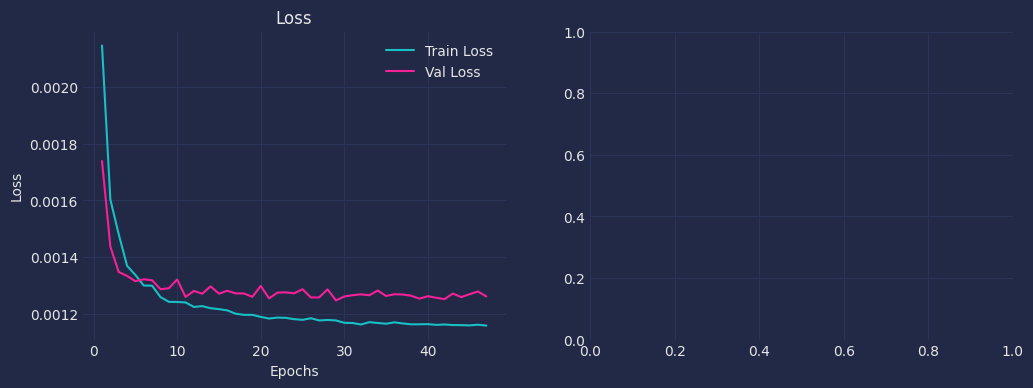

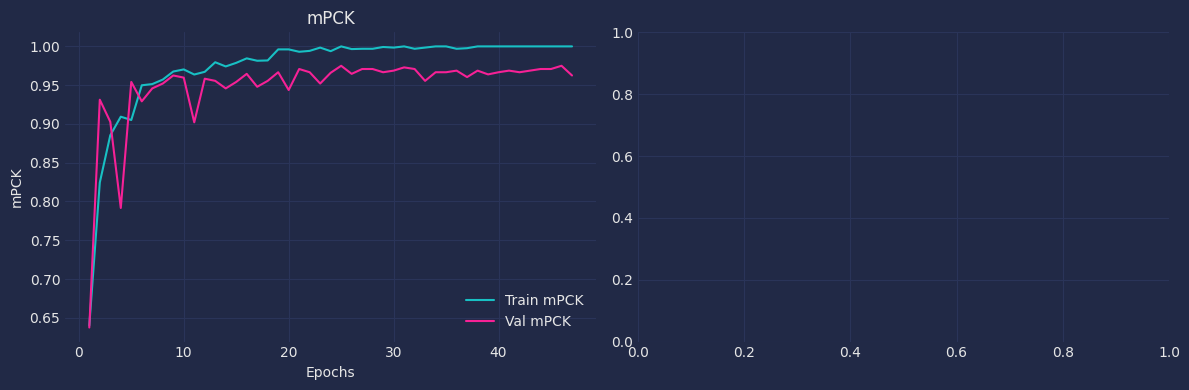

In [25]:
plot_metrics(metrics_path='hgn_2stack_focal_metrics.pkl')

In [26]:
def reverse_keypoints(keypoints, bbox, original_img_shape, crop_size=CONFIG['IM_SIZE'], grid_size=CONFIG['OUT_RES']):
    # bbox -> [x_min, y_min, x_max, y_max]
    x_min, y_min, x_max, y_max = bbox
    
    # Rescale keypoints from the model output grid (e.g., 64x64) to the cropped image size (e.g., 256x256)
    keypoints_rescaled = keypoints * (crop_size / grid_size)
    
    # Shift keypoints back to the original image coordinate space using the bbox
    keypoints_original = keypoints_rescaled + np.array([x_min, y_min])
    
    return keypoints_rescaled

In [27]:
# Function to display image with bounding box and keypoints
def display_image_with_kpts(original_img, bbox, keypoints):
    # Draw bounding box
    # x_min, y_min, x_max, y_max = map(int, bbox)
    # cv2.rectangle(original_img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green box
    
    # Draw keypoints
    for kpt in keypoints:
        x, y = int(kpt[0]), int(kpt[1])
        cv2.circle(original_img, (x, y), 3, (0, 255, 0), -1)  # Blue keypoints
    
    # Convert from BGR (OpenCV) to RGB (for displaying with matplotlib)
    img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.imshow(img_rgb)
    # plt.axis('off')
    plt.show()


image 1/1 /mnt/DL/Projects/pingpong/notebooks/training/datasets/table_tennis_table_kpts_dataset/train/images/p1-10-_jpg.rf.8c7dc3120c42eef95062d66428967074.jpg: 384x640 1 table, 8.5ms
Speed: 0.7ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].


(1, 2, 4, 1, 2)
(4, 2)
[[  1   0]
 [ 59  16]
 [124  72]
 [  3  69]]
[[          4           0]
 [        236          64]
 [        496         288]
 [         12         276]]


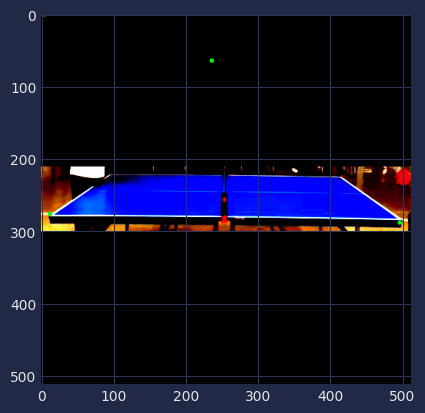


image 1/1 /mnt/DL/Projects/pingpong/notebooks/training/datasets/table_tennis_table_kpts_dataset/train/images/p1-11-_jpg.rf.12869b1a3f94495a34898283cf5e7bbe.jpg: 384x640 1 table, 8.3ms
Speed: 0.8ms preprocess, 8.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].


(1, 2, 4, 1, 2)
(4, 2)
[[  1   0]
 [108  89]
 [ 43  46]
 [  3  71]]
[[          4           0]
 [        432         356]
 [        172         184]
 [         12         284]]


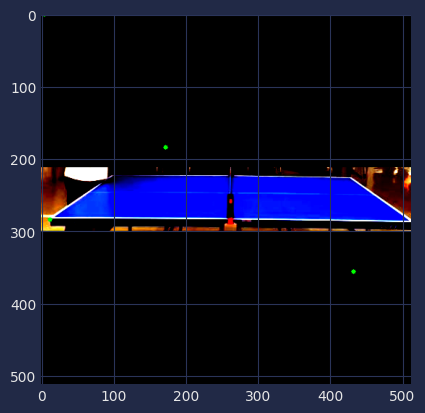


image 1/1 /mnt/DL/Projects/pingpong/notebooks/training/datasets/table_tennis_table_kpts_dataset/train/images/p1-12-_jpg.rf.4c4617e03be0933f7d92b61ed70e9c02.jpg: 384x640 1 table, 8.0ms
Speed: 0.9ms preprocess, 8.0ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].


(1, 2, 4, 1, 2)
(4, 2)
[[  1   0]
 [ 92  89]
 [125  70]
 [  3  71]]
[[          4           0]
 [        368         356]
 [        500         280]
 [         12         284]]


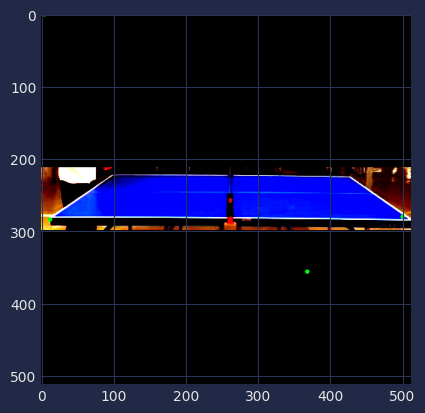


image 1/1 /mnt/DL/Projects/pingpong/notebooks/training/datasets/table_tennis_table_kpts_dataset/train/images/p1-13-_jpg.rf.e1d080c85315b50086992c6e92d5120c.jpg: 384x640 1 table, 10.5ms
Speed: 0.8ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].


(1, 2, 4, 1, 2)
(4, 2)
[[  1   0]
 [ 62  16]
 [125  70]
 [  3  71]]
[[          4           0]
 [        248          64]
 [        500         280]
 [         12         284]]


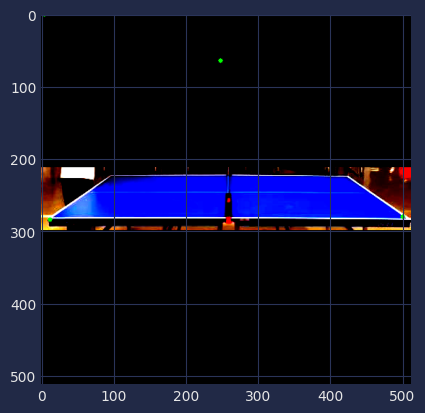


image 1/1 /mnt/DL/Projects/pingpong/notebooks/training/datasets/table_tennis_table_kpts_dataset/train/images/p1-16-_jpg.rf.65f0df09e0eb3634e07cb4819b2165e0.jpg: 384x640 1 table, 12.3ms
Speed: 0.8ms preprocess, 12.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].


(1, 2, 4, 1, 2)
(4, 2)
[[  1   0]
 [ 80  16]
 [124  70]
 [  5  71]]
[[          4           0]
 [        320          64]
 [        496         280]
 [         20         284]]


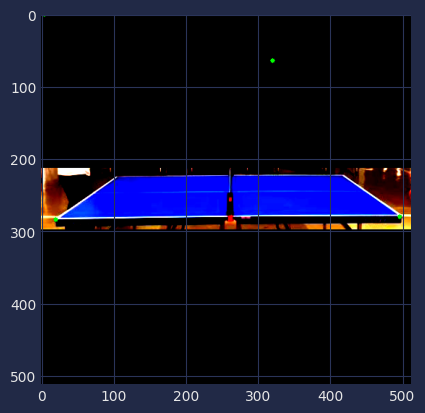


image 1/1 /mnt/DL/Projects/pingpong/notebooks/training/datasets/table_tennis_table_kpts_dataset/train/images/p1-17-_jpg.rf.97b5157b0608e845834a1896f84f64c8.jpg: 384x640 1 table, 10.7ms
Speed: 1.1ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
(1, 2, 4, 1, 2)
(4, 2)
[[ 24  55]
 [ 92  89]
 [124  70]
 [  3  70]]
[[         96         220]
 [        368         356]
 [        496         280]
 [         12         280]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].


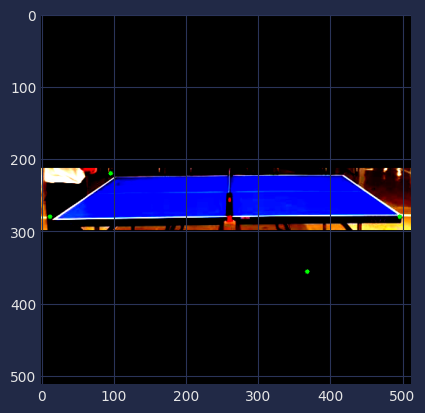

In [29]:
# Prediction pipeline
device = 'cuda' if torch.cuda.is_available() else 'cpu'
hgn_model = torch.load('/mnt/DL/Projects/pingpong/notebooks/hgn_2stack_focal.pth')
yolov8_model = YOLO('../runs/pose/train5/weights/best.pt')
hmp = HeatmapParser()
n_imgs = 5
val_images_dir = os.path.join(CONFIG['DATASET_DIR'], 'train', 'images')
with torch.no_grad():
    hgn_model.eval()
    for idx, im_name in enumerate(os.listdir(val_images_dir)):
        img_path= os.path.join(val_images_dir, im_name)
        # Run YOLOv8 on the image
        yolo_results = yolov8_model.predict(img_path)
        
        for result in yolo_results:
            boxes = result.boxes
        
            for box in boxes:
                img = cv2.imread(img_path)  # Read image with OpenCV
                
                # Albumentations expects numpy array, not tensor
                transforms = hgn_preprocess_transforms(box.xyxy[0].tolist())  # Pass bbox coordinates as list
                augments = transforms(image=img)
                
                img_augmented = augments['image']  # Get augmented image tensor

                img_augmented = img_augmented.unsqueeze(0).permute(0, 2, 3, 1).to(device)  # Add batch dimension and move to GPU
                
                # Pass the image through the hourglass model
                hgn_out = hgn_model(img_augmented)
                
                # Apply heatmap parsing (NMS)
                hgn_out_nms = hmp.nms(hgn_out).detach().cpu().numpy() 
                parsed_preds = hmp.parse(hgn_out_nms)
                print(parsed_preds['loc_k'].shape)
                parsed_preds = parsed_preds['loc_k'][0,0,:,:].squeeze(1)

                # Reverse the keypoints to the original image space
                rescaled_kpts = reverse_keypoints(parsed_preds, box.xyxy[0].cpu().numpy(), img.shape)
                # Display the original image with bounding box and keypoints
                display_image_with_kpts(augments['image'].permute(1, 2, 0).numpy(), box.xyxy[0].cpu().numpy(), rescaled_kpts)
        if idx == n_imgs:
            break

In [38]:
# Dataset evaluation pipeline
def evaluate_hgn_model_with_kpts_yolov8_dataset(dataloader, model, device):
    all_preds = []
    all_labels = []
    mPCKs = []
    extracts = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            original_imgs = inputs.numpy()
            inputs = inputs.permute(0, 2, 3, 1).to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            
            labels = labels.unsqueeze(1).repeat(1, model.nstack, 1, 1, 1).detach().cpu().numpy()  # Adjust label dimensions
            hmp = HeatmapParser()
            outputs_nms = hmp.nms(outputs).detach().cpu().numpy()
            parsed_preds = hmp.parse(outputs_nms)
            parsed_labels = hmp.parse(labels)

            all_preds.extend(parsed_preds)
            all_labels.extend(parsed_labels)
            mPCK, extracted = compute_pck(original_imgs, parsed_preds['loc_k'], parsed_labels['loc_k'], extract=[0.001])  # Calculate PCK
            mPCKs.append(mPCK)
                
    return f"mPCK: {np.mean(mPCK)}, Extracted PCKs: {extracted}"

evaluate_hgn_model_with_kpts_yolov8_dataset(hgn_train_loader, hgn_model, device)

"mPCK: 0.8125, Extracted PCKs: {'PCK@0.001': 0.25}"

## YOLOv8 nano Pose

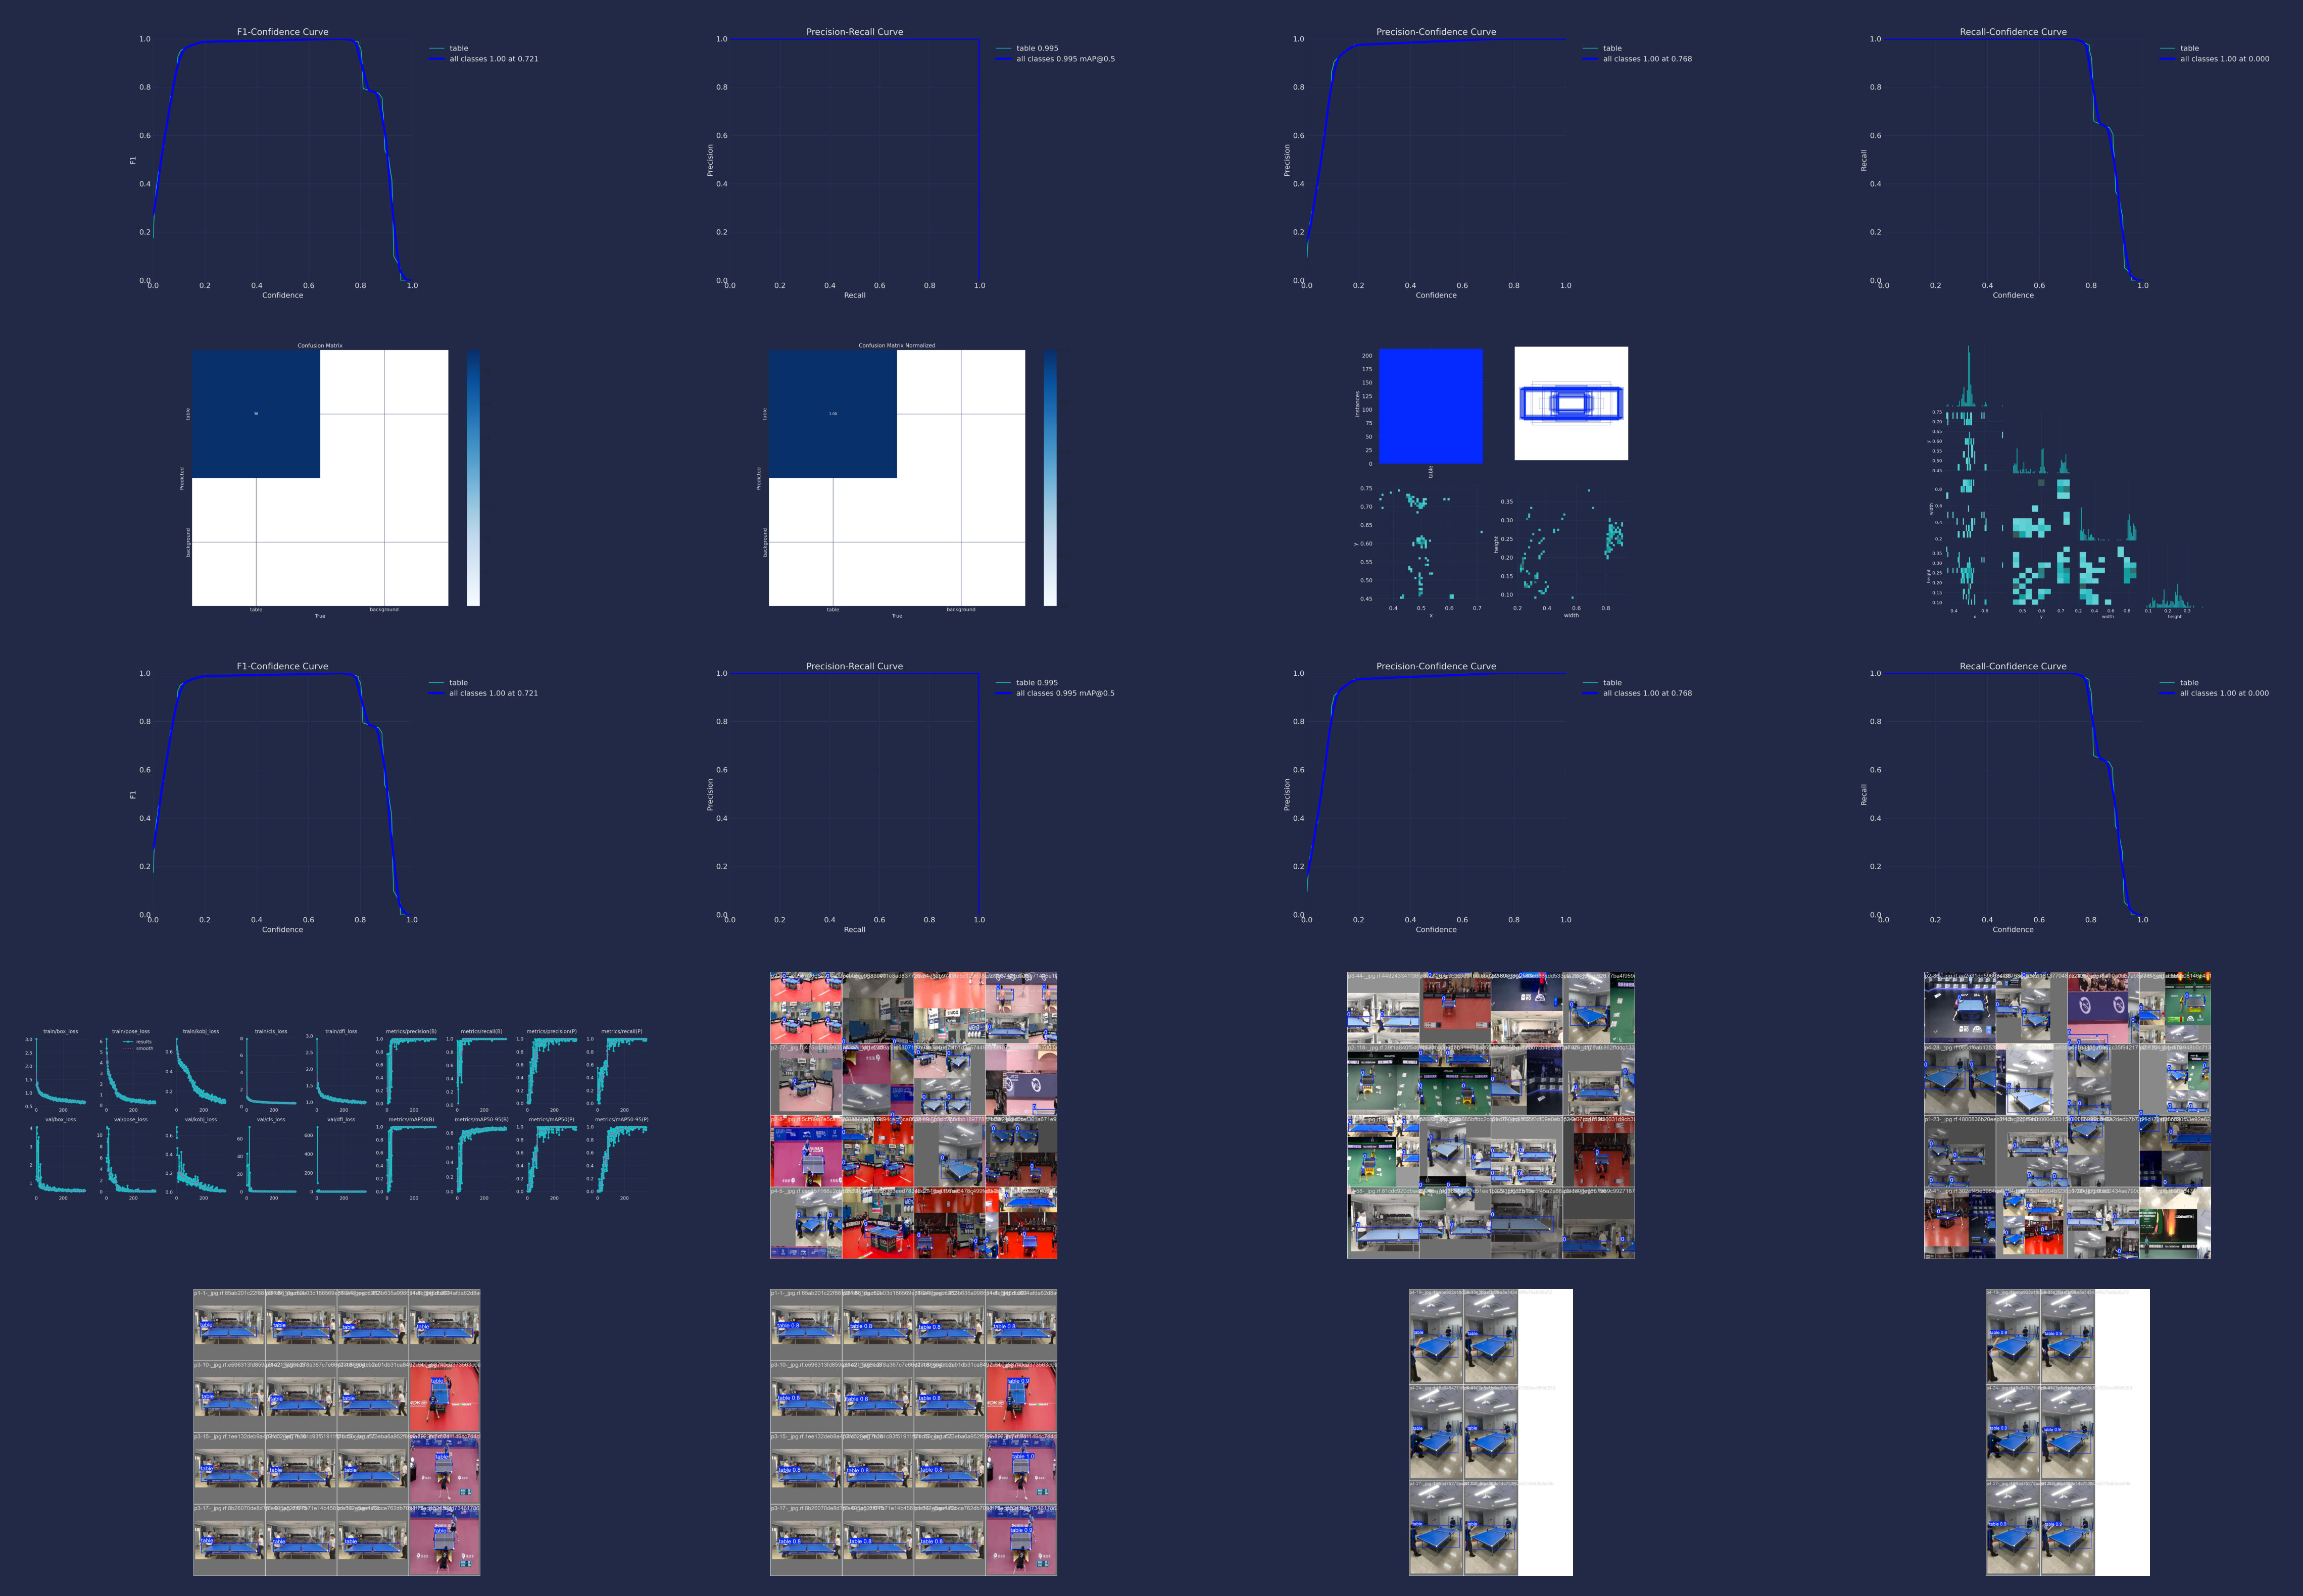

In [8]:
plot_4x('/mnt/DL/Projects/pingpong/runs/pose/train5')

## Keypoint RCNN

In [3]:
rcnn_model = torch.load('models/rcnn_kpt_w18.pth')

NameError: name 'torch' is not defined

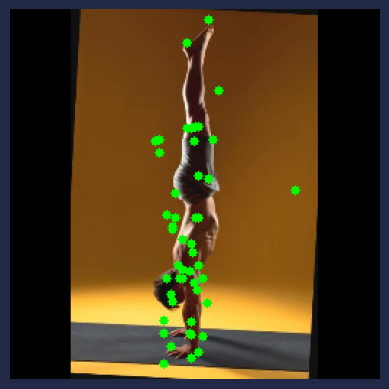

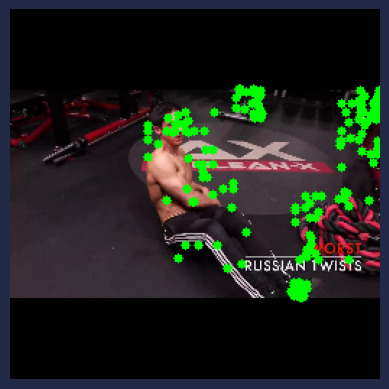

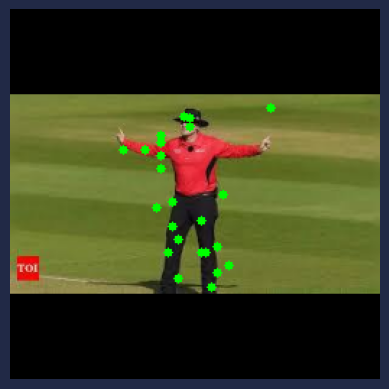

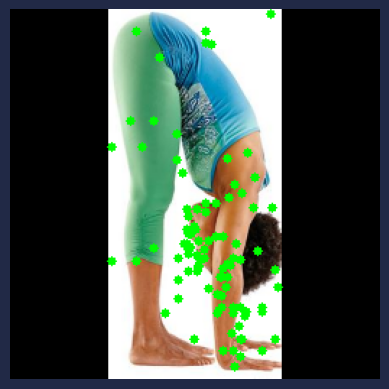

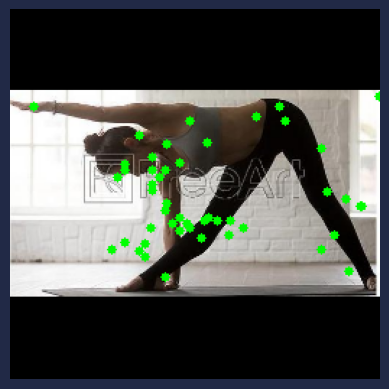

In [25]:
visualize_keypoints_from_rcnn_loader(rcnn_model, rcnn_test_loader, 5, device)

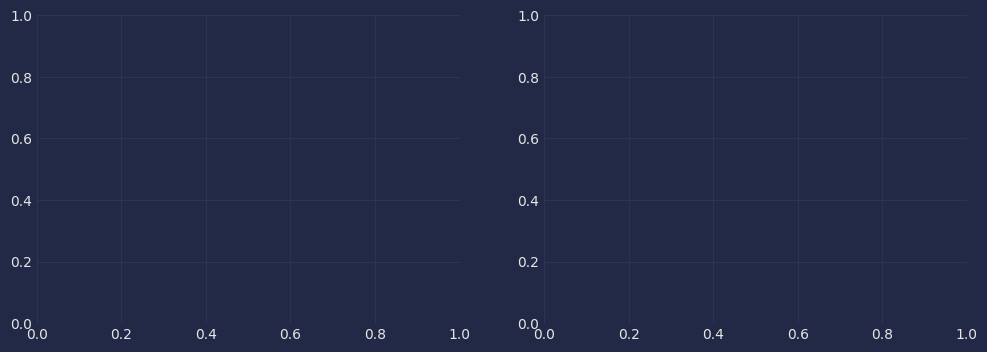

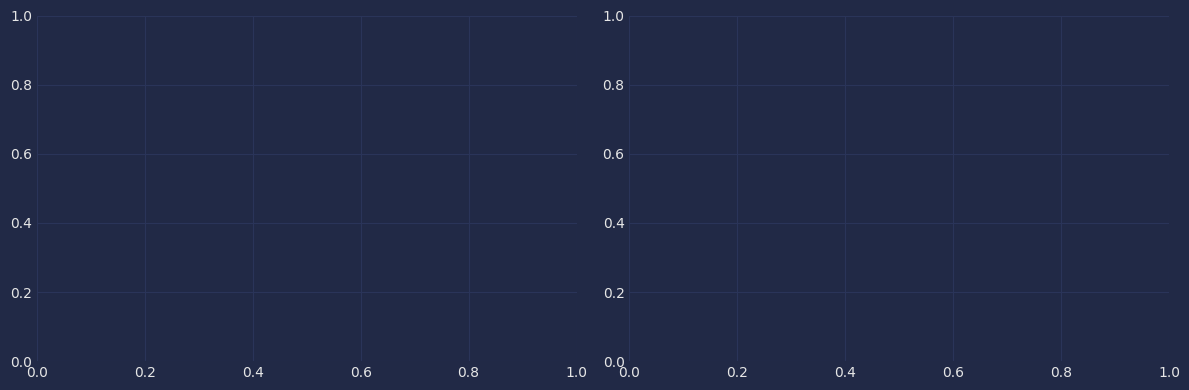

In [28]:
plot_metrics(metrics_path='models/rcnn_kpt_w18_metrics.pkl')